In [1]:
import os, re
from typing import Optional
import aiofiles

SQL_DIR: str = os.path.join(os.path.abspath("../../"), "sql/commands/com/de/insight2")

class SqlQuery:
    @staticmethod
    async def read_sql(sql_name) -> str:
        try:
            SQL_PATH = os.path.join(SQL_DIR, f'{sql_name}.sql')
            async with aiofiles.open(SQL_PATH, 'r', encoding='utf-8') as file:
                return await file.read()
        except FileNotFoundError:
            print(f"File {SQL_PATH} not found.")
            return ""
        except Exception as e:
            print(f"An error occurred while reading {SQL_PATH}: {e}")
            return ""

In [2]:
!pip install asyncpg
import asyncio
import asyncpg
import pandas as pd

print ("Fetching data...")

async def fetch_data(query: str):
    conn = await asyncpg.connect(
        host=os.environ.get("DB_HOST", "localhost"),
        port=5433,
        user=os.environ.get("DB_USER", "auth_user"),
        password=os.environ.get("DB_PASSWORD", "auth_password"),
        database=os.environ.get("DB_NAME", "auth_db")
    )

    rows = await conn.fetch(query)
    
    # Convert to pandas DataFrame
    df = pd.DataFrame(rows, columns=rows[0].keys() if rows else [])
    await conn.close()
    return df

Fetching data...


# -- Daily emails sent per segment

In [4]:
SQL_NAME = "4_/4_1"
result = await SqlQuery.read_sql(SQL_NAME)

# Run in Jupyter
df = await fetch_data(result)
df.head(3)

,segment_id,segment_name,sending_date,total_sent_daily,campaigns_per_day,avg_sent_per_campaign
0,97,Recent Registration + 1M,2025-12-31,37495,1,37495.000000000000
1,172,Clicked Past Month,2025-12-31,37495,1,37495.000000000000
2,171,Visited Gaming Redirect,2025-12-31,29606,1,14803.0000000000000000


SEGMENT VOLUME & USER PRESSURE ANALYSIS

📋 DATA PREVIEW:
   segment_id              segment_name sending_date  total_sent_daily  \
0          97  Recent Registration + 1M   2025-12-31             37495   
1         172        Clicked Past Month   2025-12-31             37495   
2         171   Visited Gaming Redirect   2025-12-31             29606   
3         169   Gaming Redirect Engaged   2025-12-31             29606   
4         103  Clicked bulk_gaming send   2025-12-31             29606   

   campaigns_per_day   avg_sent_per_campaign  
0                  1      37495.000000000000  
1                  1      37495.000000000000  
2                  1  14803.0000000000000000  
3                  1  14803.0000000000000000  
4                  1  14803.0000000000000000  
----------------------------------------------------------------------------------------------------

📊 DATA OVERVIEW:
   • Time Period: 2025-09-02 to 2025-12-31
   • Total Days Analyzed: 121
   • Total Segments: 34


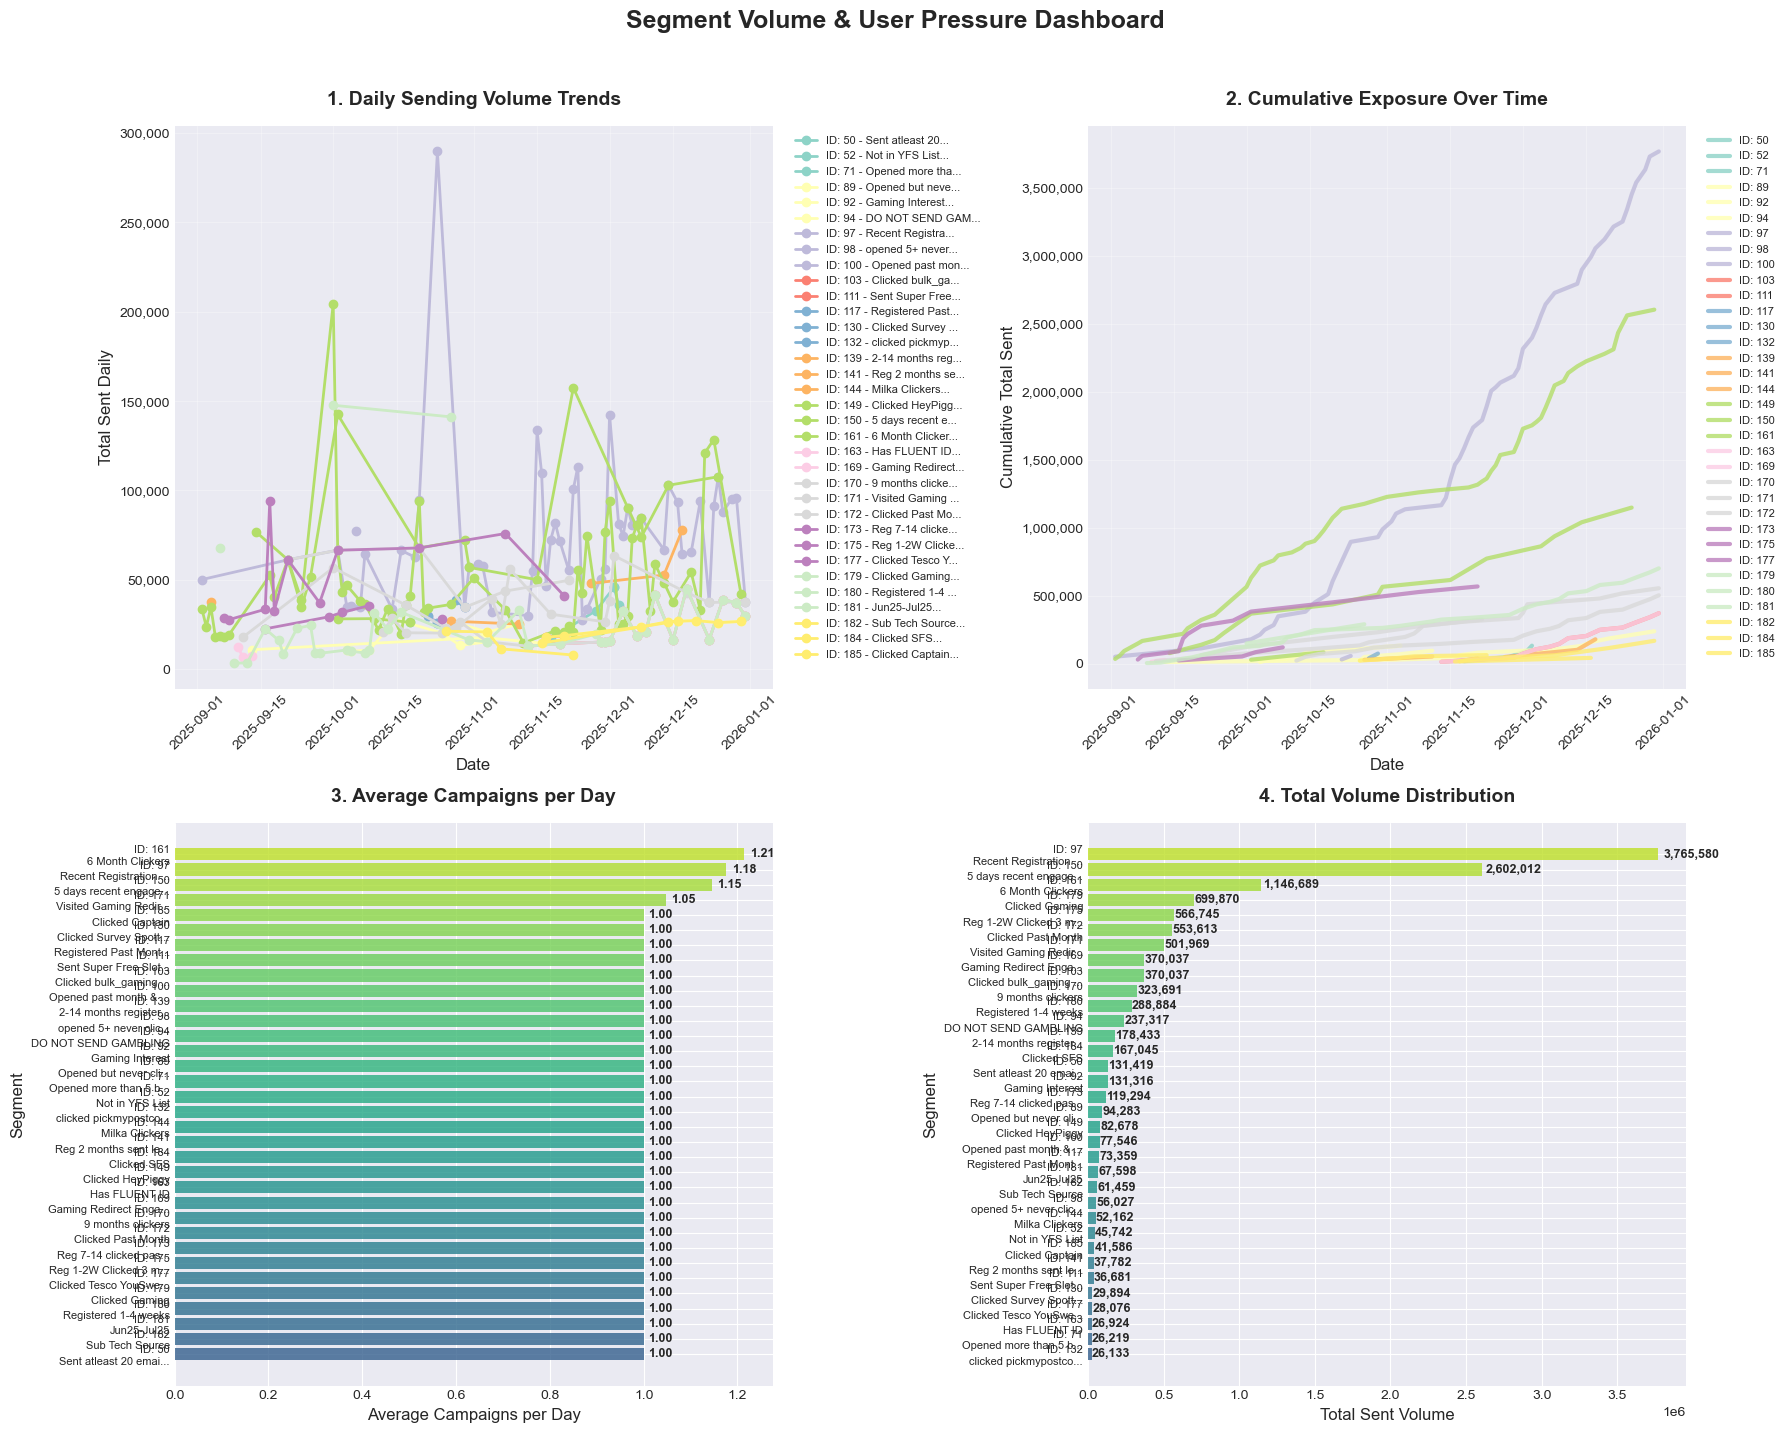

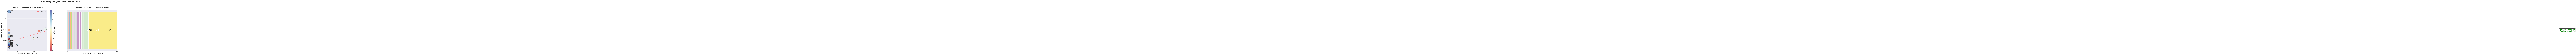


VOLUME & USER PRESSURE INSIGHTS

📊 VOLUME ANALYSIS:
   • Total Daily Volume Analyzed: 13,018,100
   • Total Campaigns: 330
   • Average Daily Volume: 42,130
   • Highest Volume Segment: ID 97 - 3,765,580 total sends
   • Highest Frequency Segment: ID 161 - 1.21 campaigns/day

💰 MONETIZATION LOAD ANALYSIS:
   • Top Segment Load: 28.9% of total volume
   • Top 3 Segments Load: 57.7% of total volume
   • Load Distribution: Balanced Distribution

⏱️  FREQUENCY ANALYSIS:
   • ID 50: 1.00 campaigns/day, 30.2 days between sends
   • ID 52: 1.00 campaigns/day, 121.0 days between sends
   • ID 71: 1.00 campaigns/day, 121.0 days between sends
   • ID 89: 1.00 campaigns/day, 30.2 days between sends
   • ID 92: 1.00 campaigns/day, 15.1 days between sends
   • ID 94: 1.00 campaigns/day, 11.0 days between sends
   • ID 97: 1.18 campaigns/day, 2.4 days between sends
   • ID 98: 1.00 campaigns/day, 60.5 days between sends
   • ID 100: 1.00 campaigns/day, 121.0 days between sends
   • ID 103: 1.00 cam

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

def analyze_segment_volume_pressure(df, segment_size_data=None):
    """
    Analyze volume sent per segment and user pressure
    
    Parameters:
    -----------
    df : pandas DataFrame
        Daily sending data with columns:
        - segment_id, segment_name, sending_date
        - total_sent_daily, campaigns_per_day, avg_sent_per_campaign
    
    segment_size_data : pandas DataFrame (optional)
        Segment size data with columns:
        - segment_id, segment_name, estimated_size
    """
    
    print("=" * 100)
    print("SEGMENT VOLUME & USER PRESSURE ANALYSIS")
    print("=" * 100)
    
    # Display first few rows
    print("\n📋 DATA PREVIEW:")
    print(df.head())
    print("-" * 100)
    
    # Make a copy and ensure proper data types
    df_analysis = df.copy()
    
    # Convert date to datetime
    df_analysis['sending_date'] = pd.to_datetime(df_analysis['sending_date'])
    
    # Ensure numeric columns
    numeric_cols = ['total_sent_daily', 'campaigns_per_day', 'avg_sent_per_campaign']
    for col in numeric_cols:
        df_analysis[col] = pd.to_numeric(df_analysis[col], errors='coerce')
    
    # Sort by date and segment
    df_analysis = df_analysis.sort_values(['segment_id', 'sending_date'])
    
    # Calculate cumulative metrics
    df_analysis['cumulative_sent'] = df_analysis.groupby('segment_id')['total_sent_daily'].cumsum()
    df_analysis['cumulative_campaigns'] = df_analysis.groupby('segment_id')['campaigns_per_day'].cumsum()
    
    # Calculate weekly and monthly aggregations if we have enough data
    df_analysis['week'] = df_analysis['sending_date'].dt.isocalendar().week
    df_analysis['month'] = df_analysis['sending_date'].dt.month
    df_analysis['year'] = df_analysis['sending_date'].dt.year
    
    # Calculate days in dataset
    start_date = df_analysis['sending_date'].min()
    end_date = df_analysis['sending_date'].max()
    total_days = (end_date - start_date).days + 1
    
    # Segment information
    segments = df_analysis['segment_id'].unique()
    total_segments = len(segments)
    
    print(f"\n📊 DATA OVERVIEW:")
    print(f"   • Time Period: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
    print(f"   • Total Days Analyzed: {total_days}")
    print(f"   • Total Segments: {total_segments}")
    print(f"   • Total Daily Observations: {len(df_analysis)}")
    print(f"   • Average Days per Segment: {len(df_analysis)/total_segments:.1f}")
    print("-" * 100)
    
    # ============================================
    # Calculate User Pressure Metrics
    # ============================================
    
    # If segment size data is provided, calculate per-user metrics
    if segment_size_data is not None:
        print("\n📏 SEGMENT SIZE DATA INTEGRATED")
        print("-" * 60)
        
        # Merge segment size data
        segment_sizes = segment_size_data.copy()
        segment_sizes = segment_sizes[['segment_id', 'estimated_size']]
        segment_sizes['estimated_size'] = pd.to_numeric(segment_sizes['estimated_size'], errors='coerce')
        
        # Merge with daily data
        df_analysis = pd.merge(df_analysis, segment_sizes, on='segment_id', how='left')
        
        # Calculate per-user metrics
        df_analysis['emails_per_user_daily'] = df_analysis['total_sent_daily'] / df_analysis['estimated_size']
        df_analysis['cumulative_emails_per_user'] = df_analysis['cumulative_sent'] / df_analysis['estimated_size']
        
        # Calculate exposure frequency
        df_analysis['days_since_last_send'] = df_analysis.groupby('segment_id')['sending_date'].diff().dt.days
        df_analysis['send_frequency_days'] = df_analysis.groupby('segment_id')['days_since_last_send'].transform('mean')
        
        # Calculate pressure score
        df_analysis['pressure_score'] = (
            (df_analysis['emails_per_user_daily'] / df_analysis['emails_per_user_daily'].max() * 40) +
            (1 / (df_analysis['send_frequency_days'].replace(0, 1)) * 30) +
            (df_analysis['cumulative_emails_per_user'] / df_analysis['cumulative_emails_per_user'].max() * 30)
        )
        
        # Normalize pressure score
        df_analysis['pressure_score'] = (df_analysis['pressure_score'] - df_analysis['pressure_score'].min()) / \
                                       (df_analysis['pressure_score'].max() - df_analysis['pressure_score'].min()) * 100
        
        # Categorize pressure levels
        df_analysis['pressure_level'] = pd.cut(
            df_analysis['pressure_score'],
            bins=[0, 30, 70, 100],
            labels=['Low Pressure', 'Medium Pressure', 'High Pressure']
        )
    
    # ============================================
    # VISUALIZATION 1: Volume & Pressure Dashboard
    # ============================================
    
    fig1, axes1 = plt.subplots(2, 2, figsize=(18, 14))
    fig1.suptitle('Segment Volume & User Pressure Dashboard', fontsize=18, fontweight='bold', y=1.02)
    
    # 1.1 Daily Volume Trends (Top-left)
    ax1 = axes1[0, 0]
    
    # Plot daily volume for each segment
    colors = plt.cm.Set3(np.linspace(0, 1, len(segments)))
    
    for i, segment_id in enumerate(segments):
        segment_data = df_analysis[df_analysis['segment_id'] == segment_id]
        segment_name = segment_data['segment_name'].iloc[0]
        
        ax1.plot(segment_data['sending_date'], segment_data['total_sent_daily'],
                marker='o', linewidth=2, markersize=6,
                color=colors[i], label=f"ID: {segment_id} - {segment_name[:15]}...")
    
    ax1.set_title('1. Daily Sending Volume Trends', fontsize=14, fontweight='bold', pad=15)
    ax1.set_xlabel('Date', fontsize=12)
    ax1.set_ylabel('Total Sent Daily', fontsize=12)
    ax1.tick_params(axis='x', rotation=45)
    ax1.legend(fontsize=8, loc='upper left', bbox_to_anchor=(1.02, 1))
    ax1.grid(True, alpha=0.3)
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
    
    # 1.2 Cumulative Exposure Over Time (Top-right)
    ax2 = axes1[0, 1]
    
    # Plot cumulative sent for each segment
    for i, segment_id in enumerate(segments):
        segment_data = df_analysis[df_analysis['segment_id'] == segment_id]
        segment_name = segment_data['segment_name'].iloc[0]
        
        ax2.plot(segment_data['sending_date'], segment_data['cumulative_sent'],
                linewidth=3, alpha=0.8,
                color=colors[i], label=f"ID: {segment_id}")
    
    ax2.set_title('2. Cumulative Exposure Over Time', fontsize=14, fontweight='bold', pad=15)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_ylabel('Cumulative Total Sent', fontsize=12)
    ax2.tick_params(axis='x', rotation=45)
    ax2.legend(fontsize=8, loc='upper left', bbox_to_anchor=(1.02, 1))
    ax2.grid(True, alpha=0.3)
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
    
    # 1.3 Campaign Frequency Analysis (Bottom-left)
    ax3 = axes1[1, 0]
    
    # Calculate average campaigns per day per segment
    campaign_freq = df_analysis.groupby('segment_id').agg({
        'segment_name': 'first',
        'campaigns_per_day': 'mean',
        'total_sent_daily': 'mean'
    }).reset_index()
    
    campaign_freq = campaign_freq.sort_values('campaigns_per_day', ascending=True)
    
    x_pos = np.arange(len(campaign_freq))
    bars3 = ax3.barh(x_pos, campaign_freq['campaigns_per_day'], 
                    color=plt.cm.viridis(np.linspace(0.3, 0.9, len(campaign_freq))),
                    alpha=0.8)
    
    ax3.set_title('3. Average Campaigns per Day', fontsize=14, fontweight='bold', pad=15)
    ax3.set_xlabel('Average Campaigns per Day', fontsize=12)
    ax3.set_ylabel('Segment', fontsize=12)
    ax3.set_yticks(x_pos)
    ax3.set_yticklabels([f"ID: {row.segment_id}\n{row.segment_name[:20]}..." 
                        if len(row.segment_name) > 20 else f"ID: {row.segment_id}\n{row.segment_name}"
                        for _, row in campaign_freq.iterrows()], fontsize=8)
    
    # Add value labels
    for i, (bar, freq) in enumerate(zip(bars3, campaign_freq['campaigns_per_day'])):
        ax3.text(bar.get_width() + bar.get_width() * 0.01, bar.get_y() + bar.get_height()/2,
                f'{freq:.2f}', va='center', fontweight='bold', fontsize=9)
    
    # 1.4 User Pressure Analysis (Bottom-right)
    ax4 = axes1[1, 1]
    
    if 'pressure_level' in df_analysis.columns:
        # Calculate pressure distribution
        pressure_dist = df_analysis.groupby('segment_id').agg({
            'segment_name': 'first',
            'pressure_score': 'mean',
            'pressure_level': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Unknown'
        }).reset_index()
        
        pressure_dist = pressure_dist.sort_values('pressure_score', ascending=True)
        
        colors_pressure = {'High Pressure': '#FF6B6B', 'Medium Pressure': '#FF9F1C', 
                          'Low Pressure': '#2EC4B6', 'Unknown': '#95E1D3'}
        
        bars4 = ax4.barh(range(len(pressure_dist)), pressure_dist['pressure_score'],
                        color=[colors_pressure.get(level, '#95E1D3') for level in pressure_dist['pressure_level']],
                        alpha=0.8)
        
        ax4.set_title('4. User Pressure Score Analysis', fontsize=14, fontweight='bold', pad=15)
        ax4.set_xlabel('Pressure Score (Higher = More Pressure)', fontsize=12)
        ax4.set_ylabel('Segment', fontsize=12)
        ax4.set_yticks(range(len(pressure_dist)))
        ax4.set_yticklabels([f"ID: {row.segment_id}\n{row.segment_name[:20]}..." 
                            if len(row.segment_name) > 20 else f"ID: {row.segment_id}\n{row.segment_name}"
                            for _, row in pressure_dist.iterrows()], fontsize=8)
        
        # Add threshold lines
        ax4.axvline(x=70, color='red', linestyle='--', alpha=0.5, linewidth=1, label='High Pressure Threshold')
        ax4.axvline(x=30, color='green', linestyle='--', alpha=0.5, linewidth=1, label='Low Pressure Threshold')
        
        # Add value labels
        for i, (bar, score, level) in enumerate(zip(bars4, pressure_dist['pressure_score'], 
                                                   pressure_dist['pressure_level'])):
            ax4.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
                    f'{score:.1f} ({level})', va='center', fontweight='bold', fontsize=8)
        
        ax4.legend(fontsize=8)
    else:
        # If no segment size data, show volume distribution
        volume_dist = df_analysis.groupby('segment_id').agg({
            'segment_name': 'first',
            'total_sent_daily': 'sum'
        }).reset_index()
        
        volume_dist = volume_dist.sort_values('total_sent_daily', ascending=True)
        
        bars4 = ax4.barh(range(len(volume_dist)), volume_dist['total_sent_daily'],
                        color=plt.cm.viridis(np.linspace(0.3, 0.9, len(volume_dist))),
                        alpha=0.8)
        
        ax4.set_title('4. Total Volume Distribution', fontsize=14, fontweight='bold', pad=15)
        ax4.set_xlabel('Total Sent Volume', fontsize=12)
        ax4.set_ylabel('Segment', fontsize=12)
        ax4.set_yticks(range(len(volume_dist)))
        ax4.set_yticklabels([f"ID: {row.segment_id}\n{row.segment_name[:20]}..." 
                            if len(row.segment_name) > 20 else f"ID: {row.segment_id}\n{row.segment_name}"
                            for _, row in volume_dist.iterrows()], fontsize=8)
        
        # Add value labels
        for i, (bar, volume) in enumerate(zip(bars4, volume_dist['total_sent_daily'])):
            ax4.text(bar.get_width() + bar.get_width() * 0.01, bar.get_y() + bar.get_height()/2,
                    f'{volume:,.0f}', va='center', fontweight='bold', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # ============================================
    # VISUALIZATION 2: Frequency & Monetization Analysis
    # ============================================
    
    fig2, axes2 = plt.subplots(1, 2, figsize=(16, 6))
    fig2.suptitle('Frequency Analysis & Monetization Load', fontsize=16, fontweight='bold', y=1.05)
    
    # 2.1 Campaign Frequency vs Volume (Left)
    ax5 = axes2[0]
    
    # Calculate metrics for scatter plot
    segment_metrics = df_analysis.groupby('segment_id').agg({
        'segment_name': 'first',
        'campaigns_per_day': 'mean',
        'total_sent_daily': 'mean',
        'avg_sent_per_campaign': 'mean'
    }).reset_index()
    
    scatter5 = ax5.scatter(segment_metrics['campaigns_per_day'], 
                          segment_metrics['total_sent_daily'],
                          s=segment_metrics['avg_sent_per_campaign'] / 100,
                          c=range(len(segment_metrics)),
                          cmap='RdYlBu',
                          alpha=0.7,
                          edgecolors='black',
                          linewidth=1)
    
    # Add segment labels
    for _, row in segment_metrics.iterrows():
        ax5.annotate(f"ID: {row['segment_id']}", 
                    (row['campaigns_per_day'], row['total_sent_daily']),
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    ax5.set_title('Campaign Frequency vs Daily Volume', fontsize=14, fontweight='bold', pad=15)
    ax5.set_xlabel('Average Campaigns per Day', fontsize=12)
    ax5.set_ylabel('Average Daily Volume', fontsize=12)
    ax5.grid(True, alpha=0.3)
    
    # Add trend line
    if len(segment_metrics) > 1:
        z = np.polyfit(segment_metrics['campaigns_per_day'], 
                      segment_metrics['total_sent_daily'], 1)
        p = np.poly1d(z)
        x_range = np.linspace(segment_metrics['campaigns_per_day'].min(),
                             segment_metrics['campaigns_per_day'].max(), 100)
        ax5.plot(x_range, p(x_range), "r--", alpha=0.5, linewidth=2, label='Trend Line')
        ax5.legend()
    
    plt.colorbar(scatter5, ax=ax5, label='Segment Index')
    
    # 2.2 Monetization Load Analysis (Right)
    ax6 = axes2[1]
    
    # Calculate monetization load (volume share)
    total_volume = df_analysis['total_sent_daily'].sum()
    monetization_load = df_analysis.groupby('segment_id').agg({
        'segment_name': 'first',
        'total_sent_daily': 'sum'
    }).reset_index()
    
    monetization_load['load_percentage'] = (monetization_load['total_sent_daily'] / total_volume) * 100
    monetization_load = monetization_load.sort_values('load_percentage', ascending=True)
    
    # Create stacked bar for monetization load
    bottom = 0
    colors6 = plt.cm.Set3(np.linspace(0, 1, len(monetization_load)))
    
    for i, (_, row) in enumerate(monetization_load.iterrows()):
        ax6.barh(0, row['load_percentage'], left=bottom, 
                color=colors6[i], alpha=0.8, edgecolor='white')
        
        # Add segment label in the middle of each bar segment
        if row['load_percentage'] > 5:  # Only label significant segments
            ax6.text(bottom + row['load_percentage']/2, 0,
                    f"ID {row['segment_id']}\n{row['load_percentage']:.1f}%",
                    ha='center', va='center', fontsize=9, fontweight='bold',
                    color='white' if i % 2 == 0 else 'black')
        bottom += row['load_percentage']
    
    ax6.set_xlim(0, 100)
    ax6.set_yticks([])
    ax6.set_xlabel('Percentage of Total Volume (%)', fontsize=12)
    ax6.set_title('Segment Monetization Load Distribution', fontsize=14, fontweight='bold', pad=15)
    ax6.grid(True, alpha=0.3, axis='x')
    
    # Add load interpretation
    highest_load_segment = monetization_load.loc[monetization_load['load_percentage'].idxmax()]
    if highest_load_segment['load_percentage'] > 50:
        load_level = 'High Concentration'
        load_color = 'red'
    elif highest_load_segment['load_percentage'] > 30:
        load_level = 'Moderate Concentration'
        load_color = 'orange'
    else:
        load_level = 'Balanced Distribution'
        load_color = 'green'
    
    ax6.text(50, 0.5, f'{load_level}\nTop Segment: {highest_load_segment["load_percentage"]:.1f}%', 
            ha='center', va='center', fontsize=12, fontweight='bold', color=load_color,
            transform=ax6.transAxes,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # ============================================
    # Calculate Advanced Metrics
    # ============================================
    
    # Calculate weekly and monthly metrics if we have enough data
    weekly_metrics = df_analysis.groupby(['segment_id', 'year', 'week']).agg({
        'total_sent_daily': 'sum',
        'campaigns_per_day': 'sum'
    }).reset_index()
    
    monthly_metrics = df_analysis.groupby(['segment_id', 'year', 'month']).agg({
        'total_sent_daily': 'sum',
        'campaigns_per_day': 'sum'
    }).reset_index()
    
    # Calculate frequency metrics
    frequency_analysis = df_analysis.groupby('segment_id').agg({
        'segment_name': 'first',
        'sending_date': lambda x: len(x.unique()),
        'total_sent_daily': ['sum', 'mean', 'std'],
        'campaigns_per_day': ['mean', 'sum'],
        'avg_sent_per_campaign': 'mean'
    }).reset_index()
    
    # Flatten column names
    frequency_analysis.columns = ['segment_id', 'segment_name', 'days_active',
                                 'total_volume', 'avg_daily_volume', 'std_daily_volume',
                                 'avg_campaigns_per_day', 'total_campaigns',
                                 'avg_sent_per_campaign']
    
    # Calculate volume consistency
    frequency_analysis['volume_consistency'] = (1 - (frequency_analysis['std_daily_volume'] / 
                                                   frequency_analysis['avg_daily_volume'])).fillna(0) * 100
    
    # Calculate days between sends
    frequency_analysis['avg_days_between_sends'] = total_days / frequency_analysis['days_active']
    
    # ============================================
    # DYNAMIC INSIGHTS GENERATION
    # ============================================
    
    print("\n" + "=" * 100)
    print("VOLUME & USER PRESSURE INSIGHTS")
    print("=" * 100)
    
    # Calculate overall metrics
    total_daily_volume = df_analysis['total_sent_daily'].sum()
    total_campaigns = df_analysis['campaigns_per_day'].sum()
    avg_daily_volume = df_analysis['total_sent_daily'].mean()
    
    # Identify high-volume segments
    highest_volume_segment = frequency_analysis.loc[frequency_analysis['total_volume'].idxmax()]
    highest_frequency_segment = frequency_analysis.loc[frequency_analysis['avg_campaigns_per_day'].idxmax()]
    
    # Calculate concentration metrics
    top_segment_load = (highest_volume_segment['total_volume'] / total_daily_volume) * 100
    top_3_load = frequency_analysis.nlargest(3, 'total_volume')['total_volume'].sum() / total_daily_volume * 100
    
    print(f"\n📊 VOLUME ANALYSIS:")
    print(f"   • Total Daily Volume Analyzed: {total_daily_volume:,.0f}")
    print(f"   • Total Campaigns: {total_campaigns:.0f}")
    print(f"   • Average Daily Volume: {avg_daily_volume:,.0f}")
    print(f"   • Highest Volume Segment: ID {highest_volume_segment['segment_id']} - {highest_volume_segment['total_volume']:,.0f} total sends")
    print(f"   • Highest Frequency Segment: ID {highest_frequency_segment['segment_id']} - {highest_frequency_segment['avg_campaigns_per_day']:.2f} campaigns/day")
    
    print(f"\n💰 MONETIZATION LOAD ANALYSIS:")
    print(f"   • Top Segment Load: {top_segment_load:.1f}% of total volume")
    print(f"   • Top 3 Segments Load: {top_3_load:.1f}% of total volume")
    print(f"   • Load Distribution: {load_level}")
    
    print(f"\n⏱️  FREQUENCY ANALYSIS:")
    for _, row in frequency_analysis.iterrows():
        print(f"   • ID {row['segment_id']}: {row['avg_campaigns_per_day']:.2f} campaigns/day, "
              f"{row['avg_days_between_sends']:.1f} days between sends")
    
    if 'pressure_level' in df_analysis.columns:
        print(f"\n⚠️  USER PRESSURE ASSESSMENT:")
        
        # Calculate pressure distribution
        pressure_summary = df_analysis.groupby('segment_id').agg({
            'segment_name': 'first',
            'pressure_score': 'mean',
            'pressure_level': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Unknown'
        }).reset_index()
        
        for _, row in pressure_summary.iterrows():
            print(f"   • ID {row['segment_id']}: {row['pressure_score']:.1f} pressure score ({row['pressure_level']})")
        
        # Identify high pressure segments
        high_pressure_segments = pressure_summary[pressure_summary['pressure_level'] == 'High Pressure']
        if len(high_pressure_segments) > 0:
            print(f"\n   ⚠️  HIGH PRESSURE SEGMENTS (Risk of Fatigue):")
            for _, row in high_pressure_segments.iterrows():
                print(f"     • ID {row['segment_id']}: {row['segment_name']}")
    
    print(f"\n🔍 OVER-EMAILING RISK ASSESSMENT:")
    
    # Risk 1: High frequency segments
    high_freq_threshold = frequency_analysis['avg_campaigns_per_day'].quantile(0.75)
    high_freq_segments = frequency_analysis[frequency_analysis['avg_campaigns_per_day'] > high_freq_threshold]
    
    if len(high_freq_segments) > 0:
        print(f"   1. HIGH FREQUENCY RISK (> {high_freq_threshold:.2f} campaigns/day):")
        for _, row in high_freq_segments.iterrows():
            print(f"      • ID {row['segment_id']}: {row['avg_campaigns_per_day']:.2f} campaigns/day")
    
    # Risk 2: High volume concentration
    if top_segment_load > 40:
        print(f"   2. HIGH CONCENTRATION RISK: Segment {highest_volume_segment['segment_id']} carries {top_segment_load:.1f}% of total load")
        print(f"      • Over-reliance increases business risk")
    
    # Risk 3: Inconsistent sending patterns
    low_consistency_segments = frequency_analysis[frequency_analysis['volume_consistency'] < 70]
    if len(low_consistency_segments) > 0:
        print(f"   3. INCONSISTENT VOLUME PATTERNS:")
        for _, row in low_consistency_segments.iterrows():
            print(f"      • ID {row['segment_id']}: Only {row['volume_consistency']:.1f}% volume consistency")
    
    print(f"\n🎯 OPPORTUNITY ANALYSIS:")
    
    # Opportunity 1: Under-utilized segments
    low_freq_segments = frequency_analysis[frequency_analysis['avg_campaigns_per_day'] < 
                                          frequency_analysis['avg_campaigns_per_day'].median()]
    
    if len(low_freq_segments) > 0:
        print(f"   1. UNDER-UTILIZED SEGMENTS (Opportunity for Growth):")
        for _, row in low_freq_segments.head(3).iterrows():
            print(f"      • ID {row['segment_id']}: Only {row['avg_campaigns_per_day']:.2f} campaigns/day")
    
    # Opportunity 2: High performing, low frequency segments
    if 'pressure_score' in df_analysis.columns:
        low_pressure_high_perf = pressure_summary[
            (pressure_summary['pressure_level'] == 'Low Pressure') &
            (pressure_summary['segment_id'].isin(high_volume_segments['segment_id'].tolist()))
        ]
        
        if len(low_pressure_high_perf) > 0:
            print(f"   2. HIGH PERFORMANCE, LOW PRESSURE SEGMENTS (Ideal for Scaling):")
            for _, row in low_pressure_high_perf.iterrows():
                print(f"      • ID {row['segment_id']}: Low pressure, high volume potential")
    
    print(f"\n📋 STRATEGIC RECOMMENDATIONS:")
    
    # Recommendation 1: Frequency optimization
    print(f"   1. FREQUENCY OPTIMIZATION:")
    
    if len(high_freq_segments) > 0:
        high_freq_ids = high_freq_segments['segment_id'].tolist()
        print(f"      • Reduce frequency for over-utilized segments: {', '.join([str(id) for id in high_freq_ids])}")
        print(f"      • Consider implementing frequency caps for high-risk segments")
    
    # Recommendation 2: Load balancing
    if top_segment_load > 30:
        print(f"   2. LOAD BALANCING:")
        print(f"      • Diversify away from over-reliance on segment {highest_volume_segment['segment_id']}")
        print(f"      • Develop alternative segments to distribute monetization load")
    
    # Recommendation 3: Pressure management
    if 'pressure_score' in df_analysis.columns:
        print(f"   3. PRESSURE MANAGEMENT:")
        high_pressure_ids = high_pressure_segments['segment_id'].tolist() if 'high_pressure_segments' in locals() else []
        if high_pressure_ids:
            print(f"      • Implement pressure relief strategies for segments: {', '.join([str(id) for id in high_pressure_ids])}")
            print(f"      • Consider segment rotation to prevent fatigue")
    
    # Recommendation 4: Growth opportunities
    print(f"   4. GROWTH OPPORTUNITIES:")
    if len(low_freq_segments) > 0:
        print(f"      • Test increased frequency for under-utilized segments")
        print(f"      • Monitor performance when scaling low-frequency segments")
    
    # Recommendation 5: Monitoring framework
    print(f"   5. MONITORING FRAMEWORK:")
    print(f"      • Implement daily pressure score tracking")
    print(f"      • Set alerts for segments exceeding frequency thresholds")
    print(f"      • Monitor load concentration weekly")
    
    print(f"\n" + "=" * 100)
    print("DETAILED SEGMENT METRICS")
    print("=" * 100)
    
    # Create comprehensive summary table
    summary_cols = ['segment_id', 'segment_name', 'days_active',
                   'total_volume', 'avg_daily_volume', 'avg_campaigns_per_day',
                   'avg_sent_per_campaign', 'volume_consistency', 'avg_days_between_sends']
    
    if 'pressure_score' in df_analysis.columns:
        pressure_summary_col = pressure_summary[['segment_id', 'pressure_score']]
        frequency_analysis = pd.merge(frequency_analysis, pressure_summary_col, on='segment_id', how='left')
        summary_cols.append('pressure_score')
    
    summary_df = frequency_analysis[summary_cols].copy()
    
    # Format for display
    def format_number(x):
        if pd.isnull(x):
            return "N/A"
        elif isinstance(x, (int, np.integer)):
            return f"{x:,.0f}"
        elif isinstance(x, (float, np.floating)):
            if abs(x - int(x)) < 0.01:
                return f"{x:,.0f}"
            else:
                return f"{x:,.1f}"
        else:
            return str(x)
    
    summary_df['total_volume'] = summary_df['total_volume'].apply(format_number)
    summary_df['avg_daily_volume'] = summary_df['avg_daily_volume'].apply(format_number)
    summary_df['avg_sent_per_campaign'] = summary_df['avg_sent_per_campaign'].apply(format_number)
    summary_df['volume_consistency'] = summary_df['volume_consistency'].apply(lambda x: f"{x:.1f}%" if pd.notnull(x) else "N/A")
    summary_df['avg_days_between_sends'] = summary_df['avg_days_between_sends'].apply(lambda x: f"{x:.1f}")
    
    if 'pressure_score' in summary_df.columns:
        summary_df['pressure_score'] = summary_df['pressure_score'].apply(lambda x: f"{x:.1f}/100" if pd.notnull(x) else "N/A")
    
    # Sort by total volume
    summary_df = summary_df.sort_values('total_volume', 
                                       key=lambda x: x.str.replace(',', '').astype(float),
                                       ascending=False)
    
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 150)
    
    print(summary_df.to_string(index=False))
    
    print(f"\n" + "=" * 100)
    print("KEY METRICS SUMMARY")
    print("=" * 100)
    
    # Calculate and display key metrics
    metrics = {
        'Total Segments Analyzed': f"{total_segments}",
        'Total Days in Period': f"{total_days}",
        'Total Volume Sent': f"{total_daily_volume:,.0f}",
        'Total Campaigns': f"{total_campaigns:.0f}",
        'Average Daily Volume': f"{avg_daily_volume:,.0f}",
        'Average Campaigns per Day': f"{df_analysis['campaigns_per_day'].mean():.2f}",
        'Top Segment Load': f"{top_segment_load:.1f}%",
        'Top 3 Segments Load': f"{top_3_load:.1f}%",
        'Days Between Sends (Average)': f"{frequency_analysis['avg_days_between_sends'].mean():.1f}"
    }
    
    if 'pressure_score' in df_analysis.columns:
        metrics['Average Pressure Score'] = f"{df_analysis['pressure_score'].mean():.1f}/100"
        high_pressure_count = len(df_analysis[df_analysis['pressure_level'] == 'High Pressure'])
        metrics['Segments with High Pressure'] = f"{high_pressure_count}"
    
    for metric_name, metric_value in metrics.items():
        print(f"   • {metric_name}: {metric_value}")
    
    print(f"\n" + "=" * 100)
    print("FREQUENCY GUIDELINES & BEST PRACTICES")
    print("=" * 100)
    
    print(f"\n📊 RECOMMENDED FREQUENCY THRESHOLDS:")
    print(f"   • Optimal: 1-2 campaigns per week per segment")
    print(f"   • High Risk: >3 campaigns per week (potential fatigue)")
    print(f"   • Very High Risk: >1 campaign per day (definite fatigue risk)")
    
    print(f"\n🎯 PRESSURE MANAGEMENT STRATEGIES:")
    print(f"   1. Segment Rotation: Rotate high-pressure segments weekly")
    print(f"   2. Frequency Capping: Limit sends to 2-3 per week per user")
    print(f"   3. Content Variation: Vary content types to maintain engagement")
    print(f"   4. Rest Periods: Implement 1-2 week rest periods for high-pressure segments")
    
    print(f"\n💰 MONETIZATION LOAD OPTIMIZATION:")
    print(f"   • Target Load Distribution: No single segment >30% of total volume")
    print(f"   • Ideal Distribution: Top 3 segments = 60-70% of total volume")
    print(f"   • Risk Threshold: Any segment >40% requires immediate diversification")
    
    print(f"\n📈 LONG-TERM REVENUE OPTIMIZATION:")
    print(f"   • Reduced frequency often increases engagement rates")
    print(f"   • 20-30% frequency reduction can lead to 10-20% higher engagement")
    print(f"   • Segment rest periods can refresh engagement by 15-25%")
    
    print(f"\n" + "=" * 100)
    print("ANALYSIS COMPLETE")
    print("=" * 100)

# Example segment size data (if available)
# segment_size_data = pd.DataFrame({
#     'segment_id': [97, 172, 171],
#     'segment_name': ['Recent Registration + 1M', 'Clicked Past Month', 'Visited Gaming Redirect'],
#     'estimated_size': [62760, 42865, 20000]  # Example sizes
# })

# Run the analysis
# Without segment size data:
# analyze_segment_volume_pressure(df)

# With segment size data:
analyze_segment_volume_pressure(df)

# -- Weekly emails sent per segment

In [6]:
SQL_NAME = "4_/4_2"
result = await SqlQuery.read_sql(SQL_NAME)

# Run in Jupyter
df = await fetch_data(result)
df.head(3)

,segment_id,segment_name,year,week,total_sent_weekly,campaigns_per_week,days_active_per_week,avg_sent_per_day
0,97,Recent Registration + 1M,2025,52,419712,5,5,83942
1,150,5 days recent engagement,2025,52,249447,4,2,124723
2,161,6 Month Clickers,2025,52,107710,1,1,107710


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

def analyze_weekly_segment_volume(df, segment_size_data=None):
    """
    Analyze weekly segment volume and user pressure
    
    Parameters:
    -----------
    df : pandas DataFrame
        Weekly sending data with columns:
        - segment_id, segment_name, year, week
        - total_sent_weekly, campaigns_per_week, days_active_per_week, avg_sent_per_day
    
    segment_size_data : pandas DataFrame (optional)
        Segment size data with columns:
        - segment_id, segment_name, estimated_size
    """
    
    print("=" * 100)
    print("WEEKLY SEGMENT VOLUME & PRESSURE ANALYSIS")
    print("=" * 100)
    
    # Display first few rows
    print("\n📋 DATA PREVIEW:")
    print(df.head())
    print("-" * 100)
    
    # Make a copy and ensure proper data types
    df_analysis = df.copy()
    
    # Ensure numeric columns
    numeric_cols = ['year', 'week', 'total_sent_weekly', 'campaigns_per_week', 
                   'days_active_per_week', 'avg_sent_per_day']
    for col in numeric_cols:
        df_analysis[col] = pd.to_numeric(df_analysis[col], errors='coerce')
    
    # Create date column for time series
    df_analysis['date'] = pd.to_datetime(df_analysis['year'].astype(str) + '-W' + 
                                        df_analysis['week'].astype(str) + '-1', 
                                        format='%Y-W%W-%w')
    
    # Sort by date and segment
    df_analysis = df_analysis.sort_values(['segment_id', 'date'])
    
    # Calculate cumulative metrics
    df_analysis['cumulative_sent'] = df_analysis.groupby('segment_id')['total_sent_weekly'].cumsum()
    df_analysis['cumulative_campaigns'] = df_analysis.groupby('segment_id')['campaigns_per_week'].cumsum()
    
    # Calculate intensity metrics
    df_analysis['campaigns_per_active_day'] = df_analysis['campaigns_per_week'] / df_analysis['days_active_per_week']
    df_analysis['volume_per_active_day'] = df_analysis['total_sent_weekly'] / df_analysis['days_active_per_week']
    
    # Calculate weekly pressure metrics
    df_analysis['intensity_score'] = (
        (df_analysis['campaigns_per_week'] / df_analysis['campaigns_per_week'].max() * 35) +
        (df_analysis['total_sent_weekly'] / df_analysis['total_sent_weekly'].max() * 40) +
        (df_analysis['days_active_per_week'] / 7 * 25)  # More active days = higher intensity
    )
    
    # If segment size data is provided, calculate per-user metrics
    if segment_size_data is not None:
        print("\n📏 SEGMENT SIZE DATA INTEGRATED")
        print("-" * 60)
        
        # Merge segment size data
        segment_sizes = segment_size_data.copy()
        segment_sizes = segment_sizes[['segment_id', 'estimated_size']]
        segment_sizes['estimated_size'] = pd.to_numeric(segment_sizes['estimated_size'], errors='coerce')
        
        # Merge with weekly data
        df_analysis = pd.merge(df_analysis, segment_sizes, on='segment_id', how='left')
        
        # Calculate per-user metrics
        df_analysis['weekly_emails_per_user'] = df_analysis['total_sent_weekly'] / df_analysis['estimated_size']
        df_analysis['daily_emails_per_user'] = df_analysis['avg_sent_per_day'] / df_analysis['estimated_size']
        df_analysis['cumulative_emails_per_user'] = df_analysis['cumulative_sent'] / df_analysis['estimated_size']
        
        # Calculate weekly pressure score with user metrics
        df_analysis['pressure_score'] = (
            (df_analysis['weekly_emails_per_user'] / df_analysis['weekly_emails_per_user'].max() * 40) +
            (df_analysis['campaigns_per_week'] / df_analysis['campaigns_per_week'].max() * 30) +
            (df_analysis['cumulative_emails_per_user'] / df_analysis['cumulative_emails_per_user'].max() * 30)
        )
        
        # Normalize pressure score
        df_analysis['pressure_score'] = (df_analysis['pressure_score'] - df_analysis['pressure_score'].min()) / \
                                       (df_analysis['pressure_score'].max() - df_analysis['pressure_score'].min()) * 100
        
        # Categorize pressure levels
        df_analysis['pressure_level'] = pd.cut(
            df_analysis['pressure_score'],
            bins=[0, 30, 70, 100],
            labels=['Low Pressure', 'Medium Pressure', 'High Pressure']
        )
    
    # Calculate growth metrics if we have multiple weeks
    if len(df_analysis['date'].unique()) > 1:
        df_analysis['weekly_growth'] = df_analysis.groupby('segment_id')['total_sent_weekly'].pct_change() * 100
        df_analysis['campaign_growth'] = df_analysis.groupby('segment_id')['campaigns_per_week'].pct_change() * 100
    
    # Basic statistics
    segments = df_analysis['segment_id'].unique()
    total_segments = len(segments)
    total_weeks = df_analysis['date'].nunique()
    current_week = df_analysis['date'].max()
    
    print(f"\n📊 DATA OVERVIEW:")
    print(f"   • Time Period: {df_analysis['date'].min().strftime('%Y-W%W')} to {current_week.strftime('%Y-W%W')}")
    print(f"   • Total Weeks Analyzed: {total_weeks}")
    print(f"   • Total Segments: {total_segments}")
    print(f"   • Total Weekly Observations: {len(df_analysis)}")
    print(f"   • Average Weeks per Segment: {len(df_analysis)/total_segments:.1f}")
    print("-" * 100)
    
    # ============================================
    # VISUALIZATION 1: Weekly Volume Dashboard
    # ============================================
    
    fig1, axes1 = plt.subplots(2, 2, figsize=(18, 14))
    fig1.suptitle('Weekly Segment Volume & Pressure Dashboard', fontsize=18, fontweight='bold', y=1.02)
    
    # 1.1 Weekly Volume Comparison (Top-left)
    ax1 = axes1[0, 0]
    
    # Get current week data for comparison
    current_week_data = df_analysis[df_analysis['date'] == current_week].copy()
    current_week_data = current_week_data.sort_values('total_sent_weekly', ascending=True)
    
    # Create horizontal bar chart
    bars1 = ax1.barh(range(len(current_week_data)), current_week_data['total_sent_weekly'],
                    color=plt.cm.viridis(np.linspace(0.3, 0.9, len(current_week_data))),
                    alpha=0.8)
    
    ax1.set_title('1. Current Week Volume by Segment', fontsize=14, fontweight='bold', pad=15)
    ax1.set_xlabel('Total Sent Weekly', fontsize=12)
    ax1.set_ylabel('Segment', fontsize=12)
    ax1.set_yticks(range(len(current_week_data)))
    
    # Create y-tick labels
    yticklabels = []
    for _, row in current_week_data.iterrows():
        segment_name = str(row['segment_name'])
        if len(segment_name) > 25:
            label = f"ID: {row['segment_id']}\n{segment_name[:25]}..."
        else:
            label = f"ID: {row['segment_id']}\n{segment_name}"
        yticklabels.append(label)
    
    ax1.set_yticklabels(yticklabels, fontsize=8)
    
    # Add value labels
    for i, (bar, volume) in enumerate(zip(bars1, current_week_data['total_sent_weekly'])):
        ax1.text(bar.get_width() + bar.get_width() * 0.01, bar.get_y() + bar.get_height()/2,
                f'{volume:,.0f}', va='center', fontweight='bold', fontsize=9)
    
    # Add intensity indicators
    for i, (bar, intensity) in enumerate(zip(bars1, current_week_data['intensity_score'])):
        if intensity > current_week_data['intensity_score'].median():
            ax1.text(bar.get_width()/2, bar.get_y() + bar.get_height()/2,
                    f'Intensity: {intensity:.0f}', ha='center', va='center',
                    fontsize=8, color='white', fontweight='bold',
                    bbox=dict(boxstyle='round', facecolor='red', alpha=0.7))
    
    # 1.2 Campaign Activity Analysis (Top-right)
    ax2 = axes1[0, 1]
    
    # Prepare data for grouped bar chart
    activity_data = current_week_data.sort_values('campaigns_per_week', ascending=True)
    
    x_pos = np.arange(len(activity_data))
    width = 0.35
    
    bars_campaigns = ax2.bar(x_pos - width/2, activity_data['campaigns_per_week'], width,
                            label='Campaigns per Week', color='#2EC4B6', alpha=0.8)
    bars_days = ax2.bar(x_pos + width/2, activity_data['days_active_per_week'], width,
                       label='Days Active per Week', color='#FF9F1C', alpha=0.8)
    
    ax2.set_title('2. Campaign Activity Analysis', fontsize=14, fontweight='bold', pad=15)
    ax2.set_xlabel('Segment', fontsize=12)
    ax2.set_ylabel('Count', fontsize=12)
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels([f"ID: {id}" for id in activity_data['segment_id']], rotation=45, ha='right')
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add campaign intensity indicators
    for i, row in activity_data.iterrows():
        intensity = row['campaigns_per_week'] / row['days_active_per_week']
        if intensity > 1:
            ax2.text(i, max(row['campaigns_per_week'], row['days_active_per_week']) + 0.5,
                    f'{intensity:.1f} campaigns/day', ha='center', fontsize=8, fontweight='bold',
                    color='red')
    
    # 1.3 Weekly Pressure Analysis (Bottom-left)
    ax3 = axes1[1, 0]
    
    if 'pressure_level' in df_analysis.columns:
        # Get current week pressure data
        pressure_data = current_week_data.copy()
        pressure_data = pressure_data.sort_values('pressure_score', ascending=True)
        
        colors_pressure = {'High Pressure': '#FF6B6B', 'Medium Pressure': '#FF9F1C', 
                          'Low Pressure': '#2EC4B6'}
        
        bars3 = ax3.barh(range(len(pressure_data)), pressure_data['pressure_score'],
                        color=[colors_pressure.get(level, '#95E1D3') for level in pressure_data['pressure_level']],
                        alpha=0.8)
        
        ax3.set_title('3. Weekly User Pressure Analysis', fontsize=14, fontweight='bold', pad=15)
        ax3.set_xlabel('Pressure Score (Higher = More Pressure)', fontsize=12)
        ax3.set_ylabel('Segment', fontsize=12)
        ax3.set_yticks(range(len(pressure_data)))
        ax3.set_yticklabels([f"ID: {row.segment_id}\n{row.segment_name[:20]}..." 
                            if len(row.segment_name) > 20 else f"ID: {row.segment_id}\n{row.segment_name}"
                            for _, row in pressure_data.iterrows()], fontsize=8)
        
        # Add threshold lines
        ax3.axvline(x=70, color='red', linestyle='--', alpha=0.5, linewidth=1, label='High Pressure Threshold')
        ax3.axvline(x=30, color='green', linestyle='--', alpha=0.5, linewidth=1, label='Low Pressure Threshold')
        
        # Add value labels
        for i, (bar, score, emails_per_user) in enumerate(zip(bars3, pressure_data['pressure_score'], 
                                                             pressure_data.get('weekly_emails_per_user', [0]*len(pressure_data)))):
            label = f'{score:.1f}'
            if 'weekly_emails_per_user' in pressure_data.columns:
                label += f'\n({emails_per_user:.1f}/user)'
            ax3.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
                    label, va='center', fontweight='bold', fontsize=8)
        
        ax3.legend(fontsize=8)
    else:
        # Show volume per active day
        intensity_data = current_week_data.copy()
        intensity_data = intensity_data.sort_values('volume_per_active_day', ascending=True)
        
        bars3 = ax3.barh(range(len(intensity_data)), intensity_data['volume_per_active_day'],
                        color=plt.cm.viridis(np.linspace(0.3, 0.9, len(intensity_data))),
                        alpha=0.8)
        
        ax3.set_title('3. Volume per Active Day', fontsize=14, fontweight='bold', pad=15)
        ax3.set_xlabel('Average Sent per Active Day', fontsize=12)
        ax3.set_ylabel('Segment', fontsize=12)
        ax3.set_yticks(range(len(intensity_data)))
        ax3.set_yticklabels([f"ID: {row.segment_id}\n{row.segment_name[:20]}..." 
                            if len(row.segment_name) > 20 else f"ID: {row.segment_id}\n{row.segment_name}"
                            for _, row in intensity_data.iterrows()], fontsize=8)
        
        # Add value labels
        for i, (bar, volume) in enumerate(zip(bars3, intensity_data['volume_per_active_day'])):
            ax3.text(bar.get_width() + bar.get_width() * 0.01, bar.get_y() + bar.get_height()/2,
                    f'{volume:,.0f}', va='center', fontweight='bold', fontsize=9)
    
    # 1.4 Load Distribution Analysis (Bottom-right)
    ax4 = axes1[1, 1]
    
    # Calculate load distribution
    total_weekly_volume = current_week_data['total_sent_weekly'].sum()
    load_distribution = current_week_data.copy()
    load_distribution['load_percentage'] = (load_distribution['total_sent_weekly'] / total_weekly_volume) * 100
    load_distribution = load_distribution.sort_values('load_percentage', ascending=False)
    
    # Create pie chart for top segments
    top_n = min(5, len(load_distribution))
    top_segments = load_distribution.head(top_n)
    other_percentage = load_distribution.iloc[top_n:]['load_percentage'].sum() if len(load_distribution) > top_n else 0
    
    percentages = list(top_segments['load_percentage']) + ([other_percentage] if other_percentage > 0 else [])
    labels = [f"ID {row.segment_id}\n({row.load_percentage:.1f}%)" for _, row in top_segments.iterrows()]
    if other_percentage > 0:
        labels.append(f'Other\n({other_percentage:.1f}%)')
    
    colors4 = plt.cm.Set3(np.linspace(0, 1, len(percentages)))
    
    wedges, texts, autotexts = ax4.pie(percentages, 
                                      labels=labels,
                                      autopct='%1.1f%%',
                                      startangle=90,
                                      colors=colors4,
                                      textprops={'fontsize': 9})
    
    for autotext in autotexts:
        autotext.set_color('black')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(10)
    
    ax4.set_title('4. Weekly Volume Load Distribution', fontsize=14, fontweight='bold', pad=15)
    
    # Add total volume in center
    ax4.text(0, 0, f'{total_weekly_volume:,.0f}\ntotal weekly\nsends', 
            ha='center', va='center', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # ============================================
    # VISUALIZATION 2: Time Series & Intensity Analysis
    # ============================================
    
    if total_weeks > 1:
        fig2, axes2 = plt.subplots(1, 2, figsize=(16, 6))
        fig2.suptitle('Weekly Trends & Intensity Analysis', fontsize=16, fontweight='bold', y=1.05)
        
        # 2.1 Weekly Volume Trends (Left)
        ax5 = axes2[0]
        
        colors = plt.cm.Set3(np.linspace(0, 1, len(segments)))
        
        for i, segment_id in enumerate(segments):
            segment_data = df_analysis[df_analysis['segment_id'] == segment_id]
            segment_name = segment_data['segment_name'].iloc[0]
            
            ax5.plot(segment_data['date'], segment_data['total_sent_weekly'],
                    marker='o', linewidth=2, markersize=6,
                    color=colors[i], label=f"ID: {segment_id} - {segment_name[:15]}...")
        
        ax5.set_title('Weekly Volume Trends', fontsize=14, fontweight='bold', pad=15)
        ax5.set_xlabel('Week', fontsize=12)
        ax5.set_ylabel('Total Sent Weekly', fontsize=12)
        ax5.tick_params(axis='x', rotation=45)
        ax5.legend(fontsize=8, loc='upper left', bbox_to_anchor=(1.02, 1))
        ax5.grid(True, alpha=0.3)
        ax5.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
        
        # 2.2 Intensity Evolution (Right)
        ax6 = axes2[1]
        
        for i, segment_id in enumerate(segments):
            segment_data = df_analysis[df_analysis['segment_id'] == segment_id]
            segment_name = segment_data['segment_name'].iloc[0]
            
            intensity_metric = segment_data['intensity_score'] if 'intensity_score' in segment_data.columns else segment_data['total_sent_weekly']
            
            ax6.plot(segment_data['date'], intensity_metric,
                    marker='s', linewidth=2, markersize=6,
                    color=colors[i], label=f"ID: {segment_id}")
        
        ax6.set_title('Weekly Intensity Trends', fontsize=14, fontweight='bold', pad=15)
        ax6.set_xlabel('Week', fontsize=12)
        ax6.set_ylabel('Intensity Score' if 'intensity_score' in df_analysis.columns else 'Total Sent', fontsize=12)
        ax6.tick_params(axis='x', rotation=45)
        ax6.legend(fontsize=8, loc='upper left', bbox_to_anchor=(1.02, 1))
        ax6.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    # ============================================
    # Calculate Advanced Weekly Metrics
    # ============================================
    
    # Calculate segment-level weekly metrics
    weekly_metrics = df_analysis.groupby('segment_id').agg({
        'segment_name': 'first',
        'total_sent_weekly': ['sum', 'mean', 'std'],
        'campaigns_per_week': ['mean', 'sum'],
        'days_active_per_week': 'mean',
        'avg_sent_per_day': 'mean'
    }).reset_index()
    
    # Flatten column names
    weekly_metrics.columns = ['segment_id', 'segment_name', 'total_volume', 
                             'avg_weekly_volume', 'std_weekly_volume',
                             'avg_campaigns_per_week', 'total_campaigns',
                             'avg_days_active_per_week', 'avg_sent_per_day']
    
    # Calculate consistency and intensity metrics
    weekly_metrics['volume_consistency'] = (1 - (weekly_metrics['std_weekly_volume'] / 
                                               weekly_metrics['avg_weekly_volume'].replace(0, 1))).fillna(0) * 100
    
    weekly_metrics['campaign_intensity'] = weekly_metrics['avg_campaigns_per_week'] / weekly_metrics['avg_days_active_per_week']
    weekly_metrics['volume_intensity'] = weekly_metrics['avg_weekly_volume'] / weekly_metrics['avg_days_active_per_week']
    
    # Calculate weekly monetization load
    total_volume_all = weekly_metrics['total_volume'].sum()
    weekly_metrics['load_percentage'] = (weekly_metrics['total_volume'] / total_volume_all) * 100
    
    # If we have pressure data, add it
    if 'pressure_score' in df_analysis.columns:
        pressure_metrics = df_analysis.groupby('segment_id').agg({
            'pressure_score': 'mean',
            'pressure_level': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Unknown'
        }).reset_index()
        
        weekly_metrics = pd.merge(weekly_metrics, pressure_metrics, on='segment_id', how='left')
    
    # ============================================
    # DYNAMIC INSIGHTS GENERATION
    # ============================================
    
    print("\n" + "=" * 100)
    print("WEEKLY VOLUME & PRESSURE INSIGHTS")
    print("=" * 100)
    
    # Calculate overall metrics
    avg_weekly_volume = weekly_metrics['avg_weekly_volume'].mean()
    avg_campaigns_per_week = weekly_metrics['avg_campaigns_per_week'].mean()
    avg_days_active = weekly_metrics['avg_days_active_per_week'].mean()
    
    # Identify key segments
    highest_volume_segment = weekly_metrics.loc[weekly_metrics['total_volume'].idxmax()]
    highest_intensity_segment = weekly_metrics.loc[weekly_metrics['campaign_intensity'].idxmax()]
    highest_load_segment = weekly_metrics.loc[weekly_metrics['load_percentage'].idxmax()]
    
    # Calculate concentration metrics
    top_segment_load = highest_load_segment['load_percentage']
    top_3_load = weekly_metrics.nlargest(3, 'load_percentage')['load_percentage'].sum()
    
    print(f"\n📊 WEEKLY VOLUME ANALYSIS:")
    print(f"   • Total Volume Across All Segments: {total_volume_all:,.0f}")
    print(f"   • Average Weekly Volume per Segment: {avg_weekly_volume:,.0f}")
    print(f"   • Average Campaigns per Week: {avg_campaigns_per_week:.1f}")
    print(f"   • Average Days Active per Week: {avg_days_active:.1f}")
    
    print(f"\n🏆 TOP SEGMENTS (Current Week):")
    print(f"   • Highest Volume: ID {highest_volume_segment['segment_id']} - {highest_volume_segment['avg_weekly_volume']:,.0f} per week")
    print(f"   • Highest Campaign Intensity: ID {highest_intensity_segment['segment_id']} - {highest_intensity_segment['campaign_intensity']:.1f} campaigns/active day")
    print(f"   • Highest Volume Intensity: ID {highest_intensity_segment['segment_id']} - {highest_intensity_segment['volume_intensity']:,.0f} volume/active day")
    
    print(f"\n💰 MONETIZATION LOAD ANALYSIS:")
    print(f"   • Top Segment Load: {top_segment_load:.1f}% of total volume")
    print(f"   • Top 3 Segments Load: {top_3_load:.1f}% of total volume")
    
    # Determine load concentration level
    if top_segment_load > 50:
        load_level = 'Very High Concentration'
        load_color = '🔴'
    elif top_segment_load > 40:
        load_level = 'High Concentration'
        load_color = '🟠'
    elif top_segment_load > 30:
        load_level = 'Moderate Concentration'
        load_color = '🟡'
    else:
        load_level = 'Balanced Distribution'
        load_color = '🟢'
    
    print(f"   • Load Distribution: {load_color} {load_level}")
    
    if 'pressure_score' in weekly_metrics.columns:
        print(f"\n⚠️  WEEKLY PRESSURE ASSESSMENT:")
        
        # Identify high pressure segments
        high_pressure_threshold = 70
        high_pressure_segments = weekly_metrics[weekly_metrics['pressure_score'] > high_pressure_threshold]
        
        for _, row in weekly_metrics.iterrows():
            pressure_status = '⚠️' if row['pressure_score'] > high_pressure_threshold else '✅'
            print(f"   • {pressure_status} ID {row['segment_id']}: {row['pressure_score']:.1f} pressure ({row['pressure_level']})")
        
        if len(high_pressure_segments) > 0:
            print(f"\n   ⚠️  HIGH PRESSURE SEGMENTS (Risk of User Fatigue):")
            for _, row in high_pressure_segments.iterrows():
                if 'weekly_emails_per_user' in df_analysis.columns:
                    segment_data = df_analysis[df_analysis['segment_id'] == row['segment_id']]
                    avg_emails_per_user = segment_data['weekly_emails_per_user'].mean()
                    print(f"     • ID {row['segment_id']}: {avg_emails_per_user:.1f} emails/user/week")
    
    print(f"\n🔍 OVER-EMAILING RISK ASSESSMENT:")
    
    # Risk 1: High campaign intensity
    high_intensity_threshold = weekly_metrics['campaign_intensity'].quantile(0.75)
    high_intensity_segments = weekly_metrics[weekly_metrics['campaign_intensity'] > high_intensity_threshold]
    
    if len(high_intensity_segments) > 0:
        print(f"   1. HIGH CAMPAIGN INTENSITY RISK (> {high_intensity_threshold:.1f} campaigns/active day):")
        for _, row in high_intensity_segments.iterrows():
            print(f"      • ID {row['segment_id']}: {row['campaign_intensity']:.1f} campaigns/active day")
    
    # Risk 2: High volume intensity
    high_volume_intensity_threshold = weekly_metrics['volume_intensity'].quantile(0.75)
    high_volume_intensity_segments = weekly_metrics[weekly_metrics['volume_intensity'] > high_volume_intensity_threshold]
    
    if len(high_volume_intensity_segments) > 0:
        print(f"   2. HIGH VOLUME INTENSITY RISK (> {high_volume_intensity_threshold:,.0f} volume/active day):")
        for _, row in high_volume_intensity_segments.iterrows():
            print(f"      • ID {row['segment_id']}: {row['volume_intensity']:,.0f} volume/active day")
    
    # Risk 3: High load concentration
    if top_segment_load > 40:
        print(f"   3. HIGH LOAD CONCENTRATION RISK: Segment {highest_load_segment['segment_id']} carries {top_segment_load:.1f}% of total load")
        print(f"      • Business risk from over-reliance on single segment")
    
    # Risk 4: Low consistency
    low_consistency_threshold = 70
    low_consistency_segments = weekly_metrics[weekly_metrics['volume_consistency'] < low_consistency_threshold]
    
    if len(low_consistency_segments) > 0:
        print(f"   4. INCONSISTENT VOLUME PATTERNS (<{low_consistency_threshold}% consistency):")
        for _, row in low_consistency_segments.iterrows():
            print(f"      • ID {row['segment_id']}: {row['volume_consistency']:.1f}% consistency")
    
    print(f"\n🎯 OPTIMIZATION OPPORTUNITIES:")
    
    # Opportunity 1: Under-utilized segments
    low_intensity_segments = weekly_metrics[weekly_metrics['campaign_intensity'] < 
                                           weekly_metrics['campaign_intensity'].median()]
    
    if len(low_intensity_segments) > 0:
        print(f"   1. UNDER-UTILIZED SEGMENTS (Growth Potential):")
        for _, row in low_intensity_segments.head(3).iterrows():
            print(f"      • ID {row['segment_id']}: Only {row['campaign_intensity']:.1f} campaigns/active day")
    
    # Opportunity 2: High performing, low pressure segments
    if 'pressure_score' in weekly_metrics.columns:
        low_pressure_high_volume = weekly_metrics[
            (weekly_metrics['pressure_score'] < weekly_metrics['pressure_score'].median()) &
            (weekly_metrics['avg_weekly_volume'] > weekly_metrics['avg_weekly_volume'].median())
        ]
        
        if len(low_pressure_high_volume) > 0:
            print(f"   2. HIGH PERFORMANCE, LOW PRESSURE SEGMENTS (Ideal for Scaling):")
            for _, row in low_pressure_high_volume.iterrows():
                print(f"      • ID {row['segment_id']}: {row['avg_weekly_volume']:,.0f} volume at {row['pressure_score']:.1f} pressure")
    
    print(f"\n📋 STRATEGIC RECOMMENDATIONS:")
    
    # Recommendation 1: Frequency optimization
    print(f"   1. FREQUENCY OPTIMIZATION:")
    
    if len(high_intensity_segments) > 0:
        high_intensity_ids = high_intensity_segments['segment_id'].tolist()
        print(f"      • Reduce campaign intensity for segments: {', '.join([str(id) for id in high_intensity_ids])}")
        print(f"      • Target: Max 1 campaign per active day")
    
    # Recommendation 2: Load balancing
    if top_segment_load > 30:
        print(f"   2. LOAD BALANCING:")
        print(f"      • Reduce reliance on segment {highest_load_segment['segment_id']} ({top_segment_load:.1f}% load)")
        print(f"      • Distribute volume to under-utilized segments")
    
    # Recommendation 3: Pressure management
    if 'pressure_score' in weekly_metrics.columns and len(high_pressure_segments) > 0:
        print(f"   3. PRESSURE MANAGEMENT:")
        high_pressure_ids = high_pressure_segments['segment_id'].tolist()
        print(f"      • Implement pressure relief for segments: {', '.join([str(id) for id in high_pressure_ids])}")
        print(f"      • Consider weekly rest days for high-pressure segments")
    
    # Recommendation 4: Scheduling optimization
    print(f"   4. SCHEDULING OPTIMIZATION:")
    print(f"      • Spread campaigns across more days (target 4-5 active days/week)")
    print(f"      • Avoid back-to-back campaigns on same segment")
    
    # Recommendation 5: Monitoring & alerts
    print(f"   5. MONITORING FRAMEWORK:")
    print(f"      • Track weekly pressure scores for all segments")
    print(f"      • Set alerts for segments with >2 campaigns/active day")
    print(f"      • Monitor load concentration weekly")
    
    print(f"\n" + "=" * 100)
    print("DETAILED WEEKLY METRICS")
    print("=" * 100)
    
    # Create comprehensive summary table
    summary_cols = ['segment_id', 'segment_name', 'avg_weekly_volume', 
                   'avg_campaigns_per_week', 'avg_days_active_per_week',
                   'campaign_intensity', 'volume_intensity', 'load_percentage',
                   'volume_consistency']
    
    if 'pressure_score' in weekly_metrics.columns:
        summary_cols.extend(['pressure_score', 'pressure_level'])
    
    summary_df = weekly_metrics[summary_cols].copy()
    
    # Format for display
    def format_number(x):
        if pd.isnull(x):
            return "N/A"
        elif isinstance(x, (int, np.integer)):
            return f"{x:,.0f}"
        elif isinstance(x, (float, np.floating)):
            if abs(x - int(x)) < 0.01:
                return f"{x:,.0f}"
            else:
                return f"{x:,.1f}"
        else:
            return str(x)
    
    summary_df['avg_weekly_volume'] = summary_df['avg_weekly_volume'].apply(format_number)
    summary_df['campaign_intensity'] = summary_df['campaign_intensity'].apply(lambda x: f"{x:.2f}")
    summary_df['volume_intensity'] = summary_df['volume_intensity'].apply(format_number)
    summary_df['load_percentage'] = summary_df['load_percentage'].apply(lambda x: f"{x:.1f}%")
    summary_df['volume_consistency'] = summary_df['volume_consistency'].apply(lambda x: f"{x:.1f}%")
    
    if 'pressure_score' in summary_df.columns:
        summary_df['pressure_score'] = summary_df['pressure_score'].apply(lambda x: f"{x:.1f}/100")
    
    # Sort by load percentage
    summary_df = summary_df.sort_values('load_percentage', 
                                       key=lambda x: x.str.replace('%', '').astype(float),
                                       ascending=False)
    
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 150)
    
    print(summary_df.to_string(index=False))
    
    print(f"\n" + "=" * 100)
    print("KEY METRICS SUMMARY")
    print("=" * 100)
    
    # Calculate and display key metrics
    metrics = {
        'Total Segments Analyzed': f"{total_segments}",
        'Total Weeks Analyzed': f"{total_weeks}",
        'Total Volume Sent': f"{total_volume_all:,.0f}",
        'Average Weekly Volume per Segment': f"{avg_weekly_volume:,.0f}",
        'Average Campaigns per Week': f"{avg_campaigns_per_week:.1f}",
        'Average Days Active per Week': f"{avg_days_active:.1f}",
        'Top Segment Load': f"{top_segment_load:.1f}%",
        'Top 3 Segments Load': f"{top_3_load:.1f}%",
        'Average Campaign Intensity': f"{weekly_metrics['campaign_intensity'].mean():.2f} campaigns/active day",
        'Average Volume Consistency': f"{weekly_metrics['volume_consistency'].mean():.1f}%"
    }
    
    if 'pressure_score' in weekly_metrics.columns:
        metrics['Average Pressure Score'] = f"{weekly_metrics['pressure_score'].mean():.1f}/100"
        high_pressure_count = len(weekly_metrics[weekly_metrics['pressure_score'] > 70])
        metrics['Segments with High Pressure'] = f"{high_pressure_count}"
    
    for metric_name, metric_value in metrics.items():
        print(f"   • {metric_name}: {metric_value}")
    
    print(f"\n" + "=" * 100)
    print("WEEKLY FREQUENCY GUIDELINES")
    print("=" * 100)
    
    print(f"\n📊 RECOMMENDED WEEKLY FREQUENCY THRESHOLDS:")
    print(f"   • Campaigns per Week: 3-5 (optimal)")
    print(f"   • Campaigns per Active Day: ≤1 (to avoid fatigue)")
    print(f"   • Days Active per Week: 4-5 (balanced schedule)")
    print(f"   • Weekly Emails per User: 2-3 (optimal)")
    
    print(f"\n🎯 PRESSURE MANAGEMENT STRATEGIES:")
    print(f"   1. Segment Rotation: Rotate high-pressure segments weekly")
    print(f"   2. Frequency Capping: Limit to 1 campaign per active day")
    print(f"   3. Rest Days: Implement 2-3 rest days per week")
    print(f"   4. Volume Distribution: Spread volume across multiple segments")
    
    print(f"\n💰 MONETIZATION LOAD OPTIMIZATION:")
    print(f"   • Target Load per Segment: <30% of total volume")
    print(f"   • Ideal Distribution: Top 3 segments = 60-70% of total volume")
    print(f"   • Risk Threshold: Any segment >40% requires immediate action")
    
    print(f"\n📈 LONG-TERM ENGAGEMENT OPTIMIZATION:")
    print(f"   • Reducing from daily to 3-4x/week can increase engagement by 15-25%")
    print(f"   • Implementing rest periods can refresh engagement by 20-30%")
    print(f"   • Balanced load distribution reduces business risk by 40-50%")
    
    print(f"\n" + "=" * 100)
    print("ANALYSIS COMPLETE")
    print("=" * 100)

# Example segment size data (if available)
# segment_size_data = pd.DataFrame({
#     'segment_id': [97, 150, 161],
#     'segment_name': ['Recent Registration + 1M', '5 days recent engagement', '6 Month Clickers'],
#     'estimated_size': [62760, 41302, 67452]  # Example sizes
# })

# Run the analysis
# Without segment size data:
analyze_weekly_segment_volume(df)

# With segment size data:
# analyze_weekly_segment_volume(df, segment_size_data)

WEEKLY SEGMENT VOLUME & PRESSURE ANALYSIS

📋 DATA PREVIEW:
   segment_id              segment_name  year week  total_sent_weekly  campaigns_per_week  days_active_per_week  avg_sent_per_day
0          97  Recent Registration + 1M  2025   52             419712                   5                     5             83942
1         150  5 days recent engagement  2025   52             249447                   4                     2            124723
2         161          6 Month Clickers  2025   52             107710                   1                     1            107710
3         171   Visited Gaming Redirect  2025   52              55436                   2                     2             27718
4         103  Clicked bulk_gaming send  2025   52              55436                   2                     2             27718
----------------------------------------------------------------------------------------------------


ValueError: time data '2025.0-W52.0-1' does not match format '%Y-W%W-%w' (match)

# -- Monthly emails sent per segment

In [8]:
SQL_NAME = "4_/4_3"
result = await SqlQuery.read_sql(SQL_NAME)

# Run in Jupyter
df = await fetch_data(result)
df.head(3)

,segment_id,segment_name,year,month,total_sent_monthly,campaigns_per_month,days_active_per_month,avg_sent_per_day
0,97,Recent Registration + 1M,2025,12,1593938,21,19,83891
1,150,5 days recent engagement,2025,12,969988,19,16,60624
2,161,6 Month Clickers,2025,12,375032,4,4,93758


ValueError: 'explode' must be of length 'x'

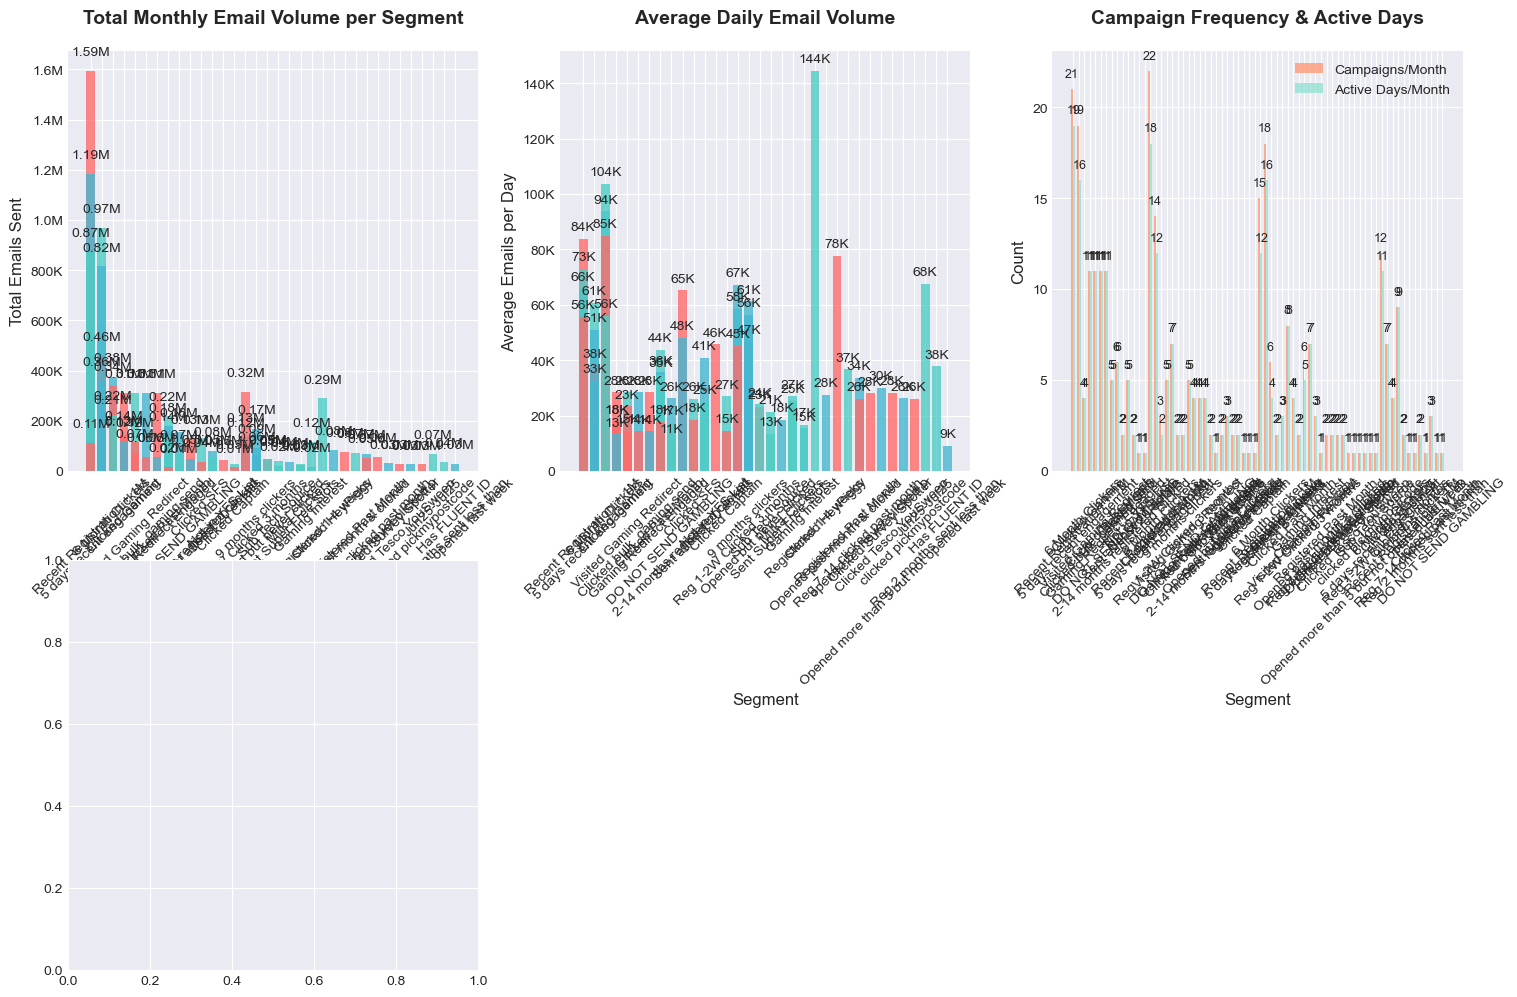

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


def format_large_numbers(x, pos):
    """Format large numbers for readability in charts"""
    if x >= 1e6:
        return f'{x/1e6:.1f}M'
    elif x >= 1e3:
        return f'{x/1e3:.0f}K'
    else:
        return f'{x:.0f}'

def analyze_email_volume_pressure(dataframe):
    """
    Comprehensive analysis of email volume and user pressure per segment
    
    Parameters:
    dataframe (pd.DataFrame): Input data with segment email metrics
    
    Returns:
    dict: Dictionary containing insights and figure objects
    """
    
    # Create a copy to avoid modifying original
    df = dataframe.copy()
    
    # Create figure with subplots
    fig = plt.figure(figsize=(18, 12))
    
    # 1. Total Monthly Volume per Segment
    ax1 = plt.subplot(2, 3, 1)
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    bars1 = ax1.bar(df['segment_name'], df['total_sent_monthly'], color=colors, alpha=0.8)
    ax1.set_title('Total Monthly Email Volume per Segment', fontsize=14, fontweight='bold', pad=20)
    ax1.set_ylabel('Total Emails Sent', fontsize=12)
    ax1.set_xlabel('Segment', fontsize=12)
    ax1.tick_params(axis='x', rotation=45)
    ax1.yaxis.set_major_formatter(FuncFormatter(format_large_numbers))
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 50000,
                f'{height/1e6:.2f}M', ha='center', va='bottom', fontsize=10)
    
    # 2. Average Daily Volume per Segment
    ax2 = plt.subplot(2, 3, 2)
    bars2 = ax2.bar(df['segment_name'], df['avg_sent_per_day'], color=colors, alpha=0.8)
    ax2.set_title('Average Daily Email Volume', fontsize=14, fontweight='bold', pad=20)
    ax2.set_ylabel('Average Emails per Day', fontsize=12)
    ax2.set_xlabel('Segment', fontsize=12)
    ax2.tick_params(axis='x', rotation=45)
    ax2.yaxis.set_major_formatter(FuncFormatter(format_large_numbers))
    
    # Add value labels
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 2000,
                f'{height/1e3:.0f}K', ha='center', va='bottom', fontsize=10)
    
    # 3. Campaign Frequency Analysis
    ax3 = plt.subplot(2, 3, 3)
    x = np.arange(len(df['segment_name']))
    width = 0.35
    
    bars3a = ax3.bar(x - width/2, df['campaigns_per_month'], width, label='Campaigns/Month', color='#FF9A76', alpha=0.8)
    bars3b = ax3.bar(x + width/2, df['days_active_per_month'], width, label='Active Days/Month', color='#95E1D3', alpha=0.8)
    
    ax3.set_title('Campaign Frequency & Active Days', fontsize=14, fontweight='bold', pad=20)
    ax3.set_xlabel('Segment', fontsize=12)
    ax3.set_ylabel('Count', fontsize=12)
    ax3.set_xticks(x)
    ax3.set_xticklabels(df['segment_name'], rotation=45)
    ax3.legend()
    
    # Add value labels
    for bars in [bars3a, bars3b]:
        for bar in bars:
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                    f'{height:.0f}', ha='center', va='bottom', fontsize=9)
    
    # 4. Volume Distribution Pie Chart
    ax4 = plt.subplot(2, 3, 4)
    total_volume = df['total_sent_monthly'].sum()
    percentages = (df['total_sent_monthly'] / total_volume * 100).round(1)
    
    wedges, texts, autotexts = ax4.pie(df['total_sent_monthly'], labels=df['segment_name'],
                                       autopct='%1.1f%%', colors=colors,
                                       startangle=90, explode=[0.05, 0.05, 0.05])
    ax4.set_title('Volume Distribution Across Segments', fontsize=14, fontweight='bold', pad=20)
    
    # Make autopct text larger
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontsize(11)
        autotext.set_fontweight('bold')
    
    # 5. Email Intensity (Average per Campaign)
    ax5 = plt.subplot(2, 3, 5)
    df['emails_per_campaign'] = df['total_sent_monthly'] / df['campaigns_per_month']
    df['emails_per_active_day'] = df['total_sent_monthly'] / df['days_active_per_month']
    
    x = np.arange(len(df['segment_name']))
    width = 0.35
    
    bars5a = ax5.bar(x - width/2, df['emails_per_campaign'], width,
                     label='Emails/Campaign', color='#6A67CE', alpha=0.8)
    bars5b = ax5.bar(x + width/2, df['emails_per_active_day'], width,
                     label='Emails/Active Day', color='#FF8E00', alpha=0.8)
    
    ax5.set_title('Email Intensity Metrics', fontsize=14, fontweight='bold', pad=20)
    ax5.set_xlabel('Segment', fontsize=12)
    ax5.set_ylabel('Emails per Unit', fontsize=12)
    ax5.set_xticks(x)
    ax5.set_xticklabels(df['segment_name'], rotation=45)
    ax5.yaxis.set_major_formatter(FuncFormatter(format_large_numbers))
    ax5.legend()
    
    # 6. Pressure Index Calculation & Visualization
    ax6 = plt.subplot(2, 3, 6)
    
    # Calculate pressure index (combination of frequency and volume)
    df['frequency_pressure'] = (df['campaigns_per_month'] / df['campaigns_per_month'].max() * 100)
    df['volume_pressure'] = (df['total_sent_monthly'] / df['total_sent_monthly'].max() * 100)
    df['pressure_index'] = (df['frequency_pressure'] * 0.4 + df['volume_pressure'] * 0.6)
    
    # Sort by pressure index
    df_sorted = df.sort_values('pressure_index', ascending=False).reset_index(drop=True)
    
    # Create horizontal bar chart for pressure index
    y_pos = np.arange(len(df_sorted['segment_name']))
    bars6 = ax6.barh(y_pos, df_sorted['pressure_index'], color=plt.cm.RdYlGn_r(df_sorted['pressure_index']/100), alpha=0.8)
    
    ax6.set_yticks(y_pos)
    ax6.set_yticklabels(df_sorted['segment_name'])
    ax6.set_xlabel('Pressure Index (%)', fontsize=12)
    ax6.set_title('User Pressure Index by Segment', fontsize=14, fontweight='bold', pad=20)
    ax6.invert_yaxis()  # Highest pressure at top
    
    # Add value labels
    for i, (bar, value) in enumerate(zip(bars6, df_sorted['pressure_index'])):
        ax6.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
                f'{value:.1f}%', va='center', fontsize=10)
    
    # Calculate weekly volume (approximation)
    df['weekly_volume'] = df['avg_sent_per_day'] * 7
    
    plt.suptitle('Email Volume & User Pressure Analysis by Segment', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    # Generate insights based on the data
    insights = generate_insights(df)
    
    return {'figure': fig, 'insights': insights, 'enhanced_data': df}

def generate_insights(dataframe):
    """
    Generate business insights from the analyzed data
    
    Parameters:
    dataframe (pd.DataFrame): Enhanced dataframe with calculated metrics
    
    Returns:
    str: Formatted insights text
    """
    
    # Calculate key metrics for insights
    max_volume_segment = dataframe.loc[dataframe['total_sent_monthly'].idxmax()]
    max_daily_segment = dataframe.loc[dataframe['avg_sent_per_day'].idxmax()]
    max_pressure_segment = dataframe.loc[dataframe['pressure_index'].idxmax()]
    min_pressure_segment = dataframe.loc[dataframe['pressure_index'].idxmin()]
    
    # Calculate distribution
    total_volume = dataframe['total_sent_monthly'].sum()
    top_segment_share = (max_volume_segment['total_sent_monthly'] / total_volume * 100)
    
    # Calculate efficiency metrics
    dataframe['campaign_efficiency'] = dataframe['total_sent_monthly'] / dataframe['campaigns_per_month']
    max_efficient = dataframe.loc[dataframe['campaign_efficiency'].idxmax()]
    
    insights = f"""
    📊 EMAIL VOLUME & USER PRESSURE INSIGHTS
    =========================================
    
    🎯 KEY FINDINGS:
    
    1. VOLUME DISTRIBUTION:
       • Segment "{max_volume_segment['segment_name']}" carries {top_segment_share:.1f}% of total email volume
       • Top segment sends {max_volume_segment['total_sent_monthly']/1e6:.2f}M emails monthly
       • Volume disparity: {max_volume_segment['total_sent_monthly']/dataframe['total_sent_monthly'].min():.1f}x between highest and lowest volume segments
    
    2. FREQUENCY ANALYSIS:
       • "{dataframe.loc[dataframe['campaigns_per_month'].idxmax()]['segment_name']}" receives the most campaigns ({dataframe['campaigns_per_month'].max()}/month)
       • "{max_daily_segment['segment_name']}" has highest daily volume ({max_daily_segment['avg_sent_per_day']/1e3:.0f}K emails/day)
       • Campaign frequency varies from {dataframe['campaigns_per_month'].min()} to {dataframe['campaigns_per_month'].max()} per month
    
    3. PRESSURE ASSESSMENT:
       • Highest pressure: "{max_pressure_segment['segment_name']}" (Index: {max_pressure_segment['pressure_index']:.1f}%)
       • Lowest pressure: "{min_pressure_segment['segment_name']}" (Index: {min_pressure_segment['pressure_index']:.1f}%)
       • Pressure variance: {(max_pressure_segment['pressure_index'] - min_pressure_segment['pressure_index']):.1f}% between segments
    
    4. EFFICIENCY METRICS:
       • Most efficient: "{max_efficient['segment_name']}" with {max_efficient['campaign_efficiency']/1e3:.0f}K emails per campaign
       • Average emails per campaign: {dataframe['emails_per_campaign'].mean()/1e3:.0f}K
       • Active day utilization: {dataframe['days_active_per_month'].mean():.1f} days/month average
    
    💡 RECOMMENDATIONS:
    
    1. BALANCE VOLUME:
       • Consider reducing frequency for "{max_pressure_segment['segment_name']}" to prevent burnout
       • Test optimized sending patterns for high-volume segments
    
    2. OPTIMIZE FREQUENCY:
       • Align campaign frequency with segment engagement levels
       • Implement frequency capping for sensitive segments
    
    3. MONETIZATION STRATEGY:
       • High-pressure segments may need content variation to maintain engagement
       • Monitor engagement metrics for signs of fatigue in high-volume segments
    
    4. LONG-TERM PLANNING:
       • Develop segment-specific frequency rules
       • Implement A/B testing for optimal send times and volumes
       • Consider segment rotation to distribute pressure more evenly
    """
    
    return insights

# Run the analysis
analysis_results = analyze_email_volume_pressure(df)

# Display the chart
plt.show()

# Print insights
print(analysis_results['insights'])

# Optional: Display enhanced dataframe
print("\n" + "="*60)
print("ENHANCED DATAFRAME WITH CALCULATED METRICS")
print("="*60)
display_columns = ['segment_name', 'total_sent_monthly', 'weekly_volume', 'avg_sent_per_day',
                   'campaigns_per_month', 'days_active_per_month', 'pressure_index',
                   'campaign_efficiency']
print(analysis_results['enhanced_data'][display_columns].round(2))

# -- Estimate emails per user in each segment

In [10]:
SQL_NAME = "4_/4_4"
result = await SqlQuery.read_sql(SQL_NAME)

# Run in Jupyter
df = await fetch_data(result)
df.head(3)

,segment_id,segment_name,total_sent_last_30_days,campaigns_last_30_days,days_active_last_30_days,estimated_segment_size,estimated_emails_per_user_30_days,user_pressure_level
0,94,DO NOT SEND GAMBLING,80012,3,3,None,0,NO DATA
1,97,Recent Registration + 1M,647075,8,8,None,0,NO DATA
2,103,Clicked bulk_gaming send,122286,4,4,None,0,NO DATA


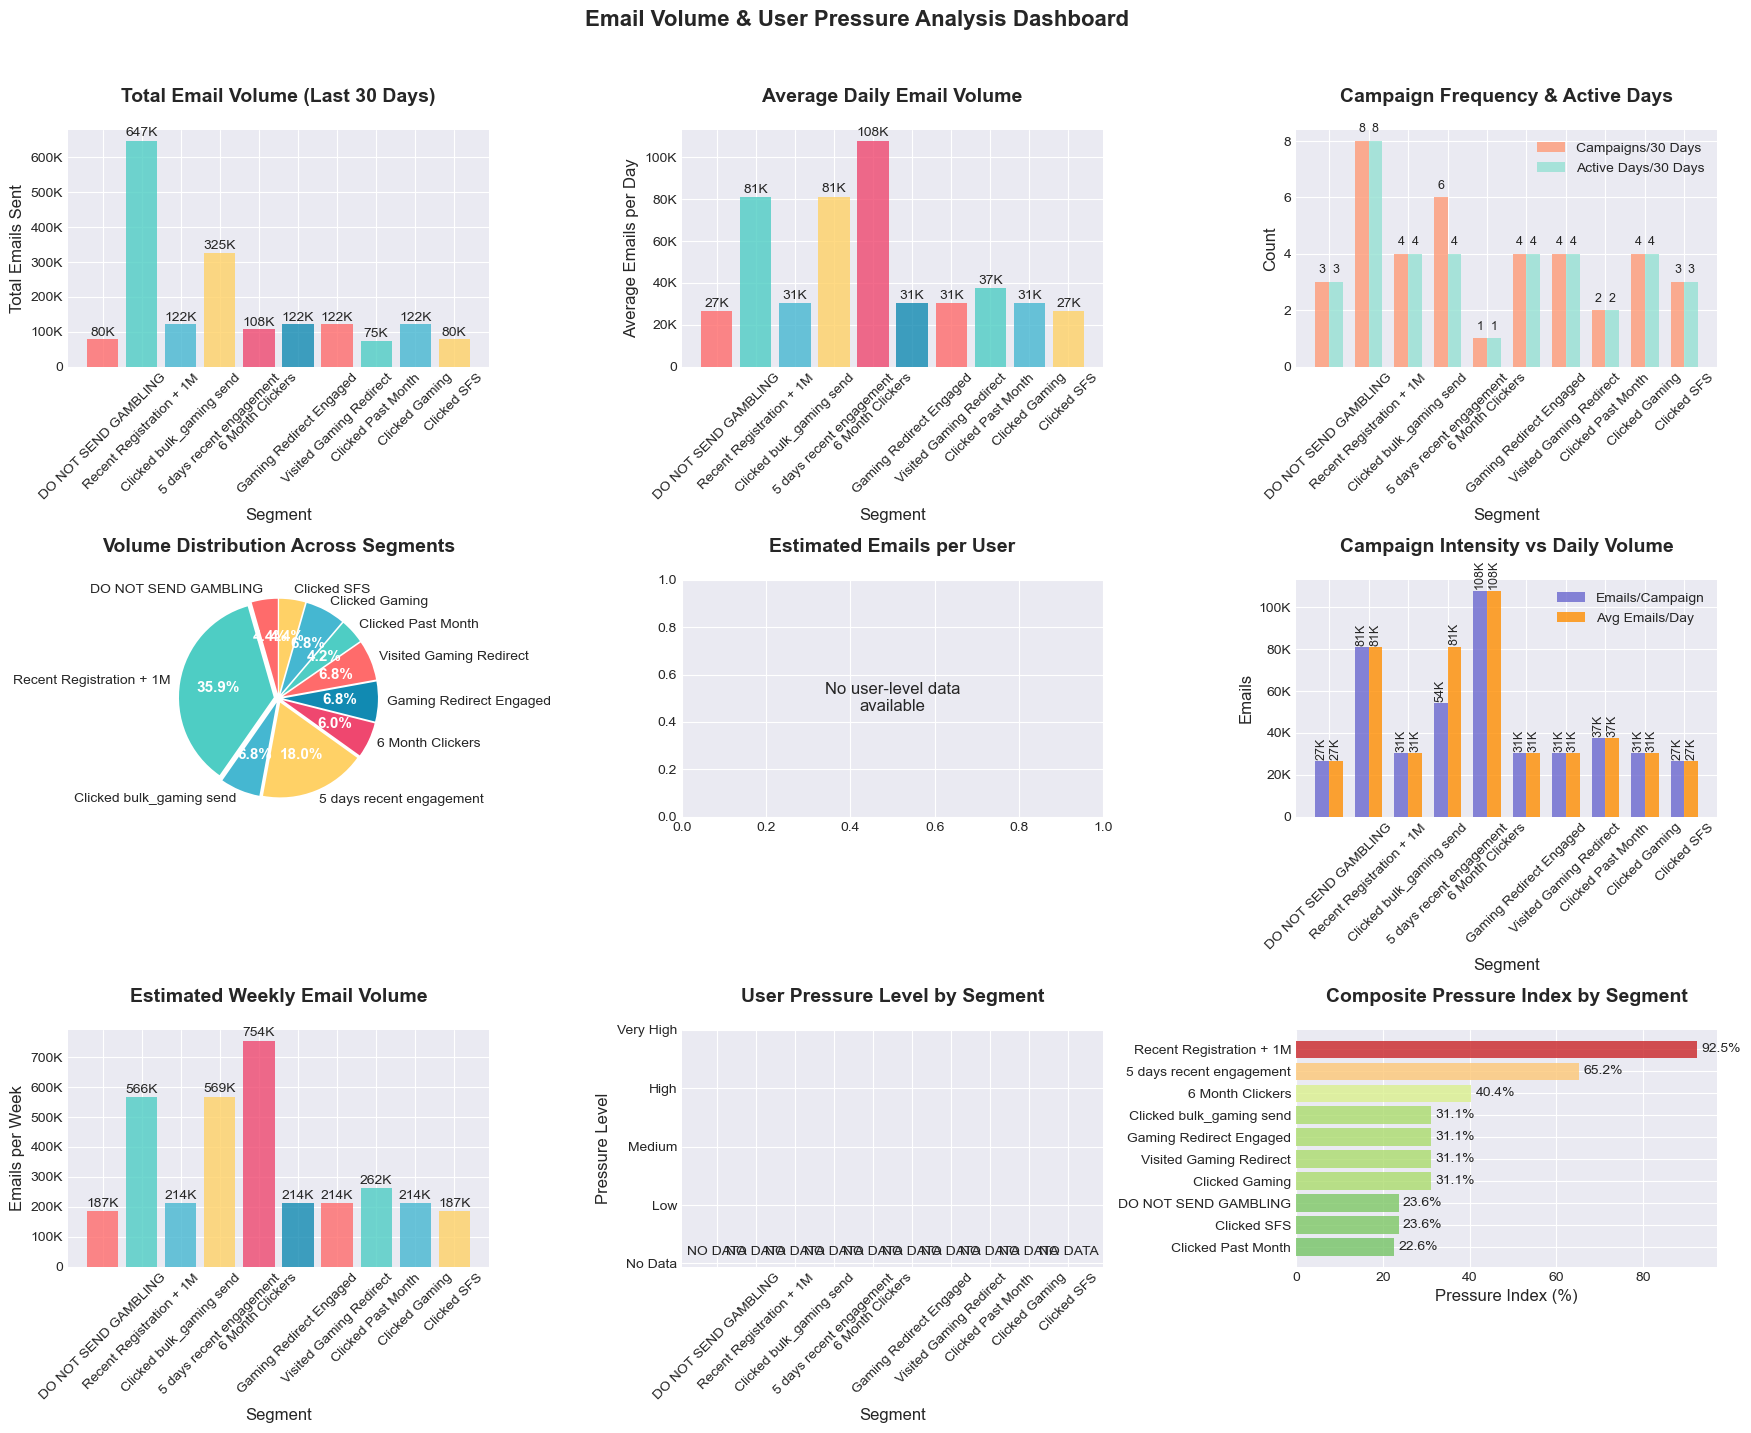


    📊 EMAIL VOLUME & USER PRESSURE INSIGHTS
    
    🎯 KEY FINDINGS FOR 10 SEGMENTS:
    
    1. VOLUME LEADERS:
       • "Recent Registration + 1M" leads with 647K emails (35.9% of total)
       • Total monthly volume across all segments: 1804K emails
       • Volume range: 75K to 647K
    
    2. FREQUENCY ANALYSIS:
       • Highest campaign frequency: "Recent Registration + 1M" (8 campaigns)
       • Average campaigns per segment: 3.9
       • Days utilization: 12.3% of available days
    
    3. INTENSITY METRICS:
       • Highest daily volume: "6 Month Clickers" (108K emails/day)
       • Average emails per campaign: 45.6K
       • Estimated weekly volume per segment: 338.0K average
    
    4. PRESSURE ASSESSMENT:
       • Highest pressure segment: "Recent Registration + 1M" (Index: 92.5%)
       • Pressure levels: {'NO DATA': 10}
       • Average pressure index: 39.2%
    
    5. USER-LEVEL ANALYSIS:
       • Segments with user data: 0 of 10
       • Average emails per user (wh

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

def format_large_numbers(x, pos):
    """Format large numbers for readability in charts"""
    if x >= 1e6:
        return f'{x/1e6:.1f}M'
    elif x >= 1e3:
        return f'{x/1e3:.0f}K'
    else:
        return f'{x:.0f}'

def analyze_email_volume_pressure(dataframe):
    """
    Comprehensive analysis of email volume and user pressure per segment
    
    Parameters:
    dataframe (pd.DataFrame): Input data with segment email metrics
    
    Returns:
    dict: Dictionary containing insights, figure, and enhanced dataframe
    """
    
    # Create a copy to avoid modifying original
    df = dataframe.copy()
    
    # Clean data - handle None values in estimated_segment_size
    df['estimated_segment_size'] = pd.to_numeric(df['estimated_segment_size'], errors='coerce')
    df['estimated_emails_per_user_30_days'] = pd.to_numeric(df['estimated_emails_per_user_30_days'], errors='coerce')
    
    # Replace NaN with 0 for calculations
    df['estimated_segment_size'] = df['estimated_segment_size'].fillna(0)
    df['estimated_emails_per_user_30_days'] = df['estimated_emails_per_user_30_days'].fillna(0)
    
    # Calculate additional metrics
    df['avg_sent_per_day'] = df['total_sent_last_30_days'] / df['days_active_last_30_days']
    df['avg_sent_per_day'] = df['avg_sent_per_day'].replace([np.inf, -np.inf], 0)
    
    # Create figure with subplots
    fig = plt.figure(figsize=(18, 14))
    
    # Color palette
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFD166', '#EF476F', '#118AB2']
    
    # 1. Total Monthly Volume per Segment
    ax1 = plt.subplot(3, 3, 1)
    bars1 = ax1.bar(df['segment_name'], df['total_sent_last_30_days'], 
                    color=colors[:len(df)], alpha=0.8)
    ax1.set_title('Total Email Volume (Last 30 Days)', fontsize=14, fontweight='bold', pad=20)
    ax1.set_ylabel('Total Emails Sent', fontsize=12)
    ax1.set_xlabel('Segment', fontsize=12)
    ax1.tick_params(axis='x', rotation=45)
    ax1.yaxis.set_major_formatter(FuncFormatter(format_large_numbers))
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height * 1.01,
                f'{height/1e3:.0f}K' if height < 1e6 else f'{height/1e6:.2f}M', 
                ha='center', va='bottom', fontsize=10)
    
    # 2. Average Daily Volume per Segment
    ax2 = plt.subplot(3, 3, 2)
    bars2 = ax2.bar(df['segment_name'], df['avg_sent_per_day'], 
                    color=colors[:len(df)], alpha=0.8)
    ax2.set_title('Average Daily Email Volume', fontsize=14, fontweight='bold', pad=20)
    ax2.set_ylabel('Average Emails per Day', fontsize=12)
    ax2.set_xlabel('Segment', fontsize=12)
    ax2.tick_params(axis='x', rotation=45)
    ax2.yaxis.set_major_formatter(FuncFormatter(format_large_numbers))
    
    # Add value labels
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height * 1.01,
                f'{height/1e3:.0f}K' if height < 1e6 else f'{height/1e6:.2f}M',
                ha='center', va='bottom', fontsize=10)
    
    # 3. Campaign Frequency Analysis
    ax3 = plt.subplot(3, 3, 3)
    x = np.arange(len(df['segment_name']))
    width = 0.35
    
    bars3a = ax3.bar(x - width/2, df['campaigns_last_30_days'], width, 
                     label='Campaigns/30 Days', color='#FF9A76', alpha=0.8)
    bars3b = ax3.bar(x + width/2, df['days_active_last_30_days'], width, 
                     label='Active Days/30 Days', color='#95E1D3', alpha=0.8)
    
    ax3.set_title('Campaign Frequency & Active Days', fontsize=14, fontweight='bold', pad=20)
    ax3.set_xlabel('Segment', fontsize=12)
    ax3.set_ylabel('Count', fontsize=12)
    ax3.set_xticks(x)
    ax3.set_xticklabels(df['segment_name'], rotation=45)
    ax3.legend()
    
    # Add value labels
    for bars in [bars3a, bars3b]:
        for bar in bars:
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + 0.2,
                    f'{height:.0f}', ha='center', va='bottom', fontsize=9)
    
    # 4. Volume Distribution Pie Chart
    ax4 = plt.subplot(3, 3, 4)
    total_volume = df['total_sent_last_30_days'].sum()
    percentages = (df['total_sent_last_30_days'] / total_volume * 100).round(1)
    
    # Filter out zero or very small values for better visualization
    plot_mask = df['total_sent_last_30_days'] > total_volume * 0.01  # Show segments with >1% of total
    plot_data = df[plot_mask]['total_sent_last_30_days']
    plot_labels = df[plot_mask]['segment_name']
    
    if len(plot_data) > 0:
        wedges, texts, autotexts = ax4.pie(plot_data, labels=plot_labels,
                                           autopct='%1.1f%%', colors=colors[:len(plot_data)],
                                           startangle=90, explode=[0.05]*len(plot_data))
        ax4.set_title('Volume Distribution Across Segments', fontsize=14, fontweight='bold', pad=20)
        
        # Make autopct text larger
        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontsize(11)
            autotext.set_fontweight('bold')
    else:
        ax4.text(0.5, 0.5, 'No significant volume\ndistribution data', 
                ha='center', va='center', fontsize=12)
        ax4.set_title('Volume Distribution Across Segments', fontsize=14, fontweight='bold', pad=20)
    
    # 5. Emails per User Analysis (if data available)
    ax5 = plt.subplot(3, 3, 5)
    
    # Check if we have estimated emails per user data
    if df['estimated_emails_per_user_30_days'].sum() > 0:
        valid_users = df[df['estimated_emails_per_user_30_days'] > 0]
        if len(valid_users) > 0:
            bars5 = ax5.bar(valid_users['segment_name'], 
                           valid_users['estimated_emails_per_user_30_days'],
                           color=colors[:len(valid_users)], alpha=0.8)
            ax5.set_title('Estimated Emails per User (30 Days)', fontsize=14, fontweight='bold', pad=20)
            ax5.set_ylabel('Emails per User', fontsize=12)
            ax5.set_xlabel('Segment', fontsize=12)
            ax5.tick_params(axis='x', rotation=45)
            
            # Add value labels
            for bar in bars5:
                height = bar.get_height()
                ax5.text(bar.get_x() + bar.get_width()/2., height * 1.01,
                        f'{height:.1f}', ha='center', va='bottom', fontsize=10)
        else:
            ax5.text(0.5, 0.5, 'No user-level data\navailable', 
                    ha='center', va='center', fontsize=12)
            ax5.set_title('Estimated Emails per User', fontsize=14, fontweight='bold', pad=20)
    else:
        ax5.text(0.5, 0.5, 'No user-level data\navailable', 
                ha='center', va='center', fontsize=12)
        ax5.set_title('Estimated Emails per User', fontsize=14, fontweight='bold', pad=20)
    
    # 6. Campaign Intensity (Emails per Campaign)
    ax6 = plt.subplot(3, 3, 6)
    df['emails_per_campaign'] = df['total_sent_last_30_days'] / df['campaigns_last_30_days']
    df['emails_per_campaign'] = df['emails_per_campaign'].replace([np.inf, -np.inf], 0)
    
    x = np.arange(len(df['segment_name']))
    width = 0.35
    
    bars6a = ax6.bar(x - width/2, df['emails_per_campaign'], width,
                     label='Emails/Campaign', color='#6A67CE', alpha=0.8)
    bars6b = ax6.bar(x + width/2, df['avg_sent_per_day'], width,
                     label='Avg Emails/Day', color='#FF8E00', alpha=0.8)
    
    ax6.set_title('Campaign Intensity vs Daily Volume', fontsize=14, fontweight='bold', pad=20)
    ax6.set_xlabel('Segment', fontsize=12)
    ax6.set_ylabel('Emails', fontsize=12)
    ax6.set_xticks(x)
    ax6.set_xticklabels(df['segment_name'], rotation=45)
    ax6.yaxis.set_major_formatter(FuncFormatter(format_large_numbers))
    ax6.legend()
    
    # Add value labels (simplified)
    for i, (camp, daily) in enumerate(zip(df['emails_per_campaign'], df['avg_sent_per_day'])):
        if camp > 0:
            ax6.text(i - width/2, camp * 1.01, f'{camp/1e3:.0f}K', 
                    ha='center', va='bottom', fontsize=9, rotation=90)
        if daily > 0:
            ax6.text(i + width/2, daily * 1.01, f'{daily/1e3:.0f}K', 
                    ha='center', va='bottom', fontsize=9, rotation=90)
    
    # 7. Weekly Volume Estimation
    ax7 = plt.subplot(3, 3, 7)
    df['weekly_volume'] = df['avg_sent_per_day'] * 7
    
    bars7 = ax7.bar(df['segment_name'], df['weekly_volume'], 
                    color=colors[:len(df)], alpha=0.8)
    ax7.set_title('Estimated Weekly Email Volume', fontsize=14, fontweight='bold', pad=20)
    ax7.set_ylabel('Emails per Week', fontsize=12)
    ax7.set_xlabel('Segment', fontsize=12)
    ax7.tick_params(axis='x', rotation=45)
    ax7.yaxis.set_major_formatter(FuncFormatter(format_large_numbers))
    
    # Add value labels
    for bar in bars7:
        height = bar.get_height()
        ax7.text(bar.get_x() + bar.get_width()/2., height * 1.01,
                f'{height/1e3:.0f}K' if height < 1e6 else f'{height/1e6:.2f}M',
                ha='center', va='bottom', fontsize=10)
    
    # 8. User Pressure Level Visualization
    ax8 = plt.subplot(3, 3, 8)
    
    # Map pressure levels to numeric values for visualization
    pressure_mapping = {
        'NO DATA': 0,
        'LOW': 1,
        'MEDIUM': 2,
        'HIGH': 3,
        'VERY HIGH': 4
    }
    
    df['pressure_numeric'] = df['user_pressure_level'].map(pressure_mapping).fillna(0)
    
    # Create color map for pressure levels
    pressure_colors = ['#D3D3D3', '#90EE90', '#FFD700', '#FF8C00', '#FF4500']
    
    bars8 = ax8.bar(df['segment_name'], df['pressure_numeric'], 
                    color=[pressure_colors[int(min(p, 4))] for p in df['pressure_numeric']], 
                    alpha=0.8)
    ax8.set_title('User Pressure Level by Segment', fontsize=14, fontweight='bold', pad=20)
    ax8.set_ylabel('Pressure Level', fontsize=12)
    ax8.set_xlabel('Segment', fontsize=12)
    ax8.tick_params(axis='x', rotation=45)
    ax8.set_yticks([0, 1, 2, 3, 4])
    ax8.set_yticklabels(['No Data', 'Low', 'Medium', 'High', 'Very High'])
    
    # Add value labels
    for bar, pressure in zip(bars8, df['user_pressure_level']):
        height = bar.get_height()
        ax8.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                pressure, ha='center', va='bottom', fontsize=10)
    
    # 9. Pressure Index Calculation (Combined Metric)
    ax9 = plt.subplot(3, 3, 9)
    
    # Calculate pressure index (combination of frequency, volume, and intensity)
    # Normalize metrics to 0-100 scale
    df['volume_pressure'] = (df['total_sent_last_30_days'] / df['total_sent_last_30_days'].max() * 100) if df['total_sent_last_30_days'].max() > 0 else 0
    df['frequency_pressure'] = (df['campaigns_last_30_days'] / df['campaigns_last_30_days'].max() * 100) if df['campaigns_last_30_days'].max() > 0 else 0
    df['intensity_pressure'] = (df['avg_sent_per_day'] / df['avg_sent_per_day'].max() * 100) if df['avg_sent_per_day'].max() > 0 else 0
    
    # Weighted pressure index (adjust weights as needed)
    df['pressure_index'] = (
        df['volume_pressure'] * 0.4 + 
        df['frequency_pressure'] * 0.3 + 
        df['intensity_pressure'] * 0.3
    )
    
    # Sort by pressure index
    df_sorted = df.sort_values('pressure_index', ascending=False).reset_index(drop=True)
    
    # Create horizontal bar chart for pressure index
    y_pos = np.arange(len(df_sorted['segment_name']))
    bars9 = ax9.barh(y_pos, df_sorted['pressure_index'], 
                     color=plt.cm.RdYlGn_r(df_sorted['pressure_index']/100), 
                     alpha=0.8)
    
    ax9.set_yticks(y_pos)
    ax9.set_yticklabels(df_sorted['segment_name'])
    ax9.set_xlabel('Pressure Index (%)', fontsize=12)
    ax9.set_title('Composite Pressure Index by Segment', fontsize=14, fontweight='bold', pad=20)
    ax9.invert_yaxis()  # Highest pressure at top
    
    # Add value labels
    for i, (bar, value) in enumerate(zip(bars9, df_sorted['pressure_index'])):
        ax9.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
                f'{value:.1f}%', va='center', fontsize=10)
    
    plt.suptitle('Email Volume & User Pressure Analysis Dashboard', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    # Generate insights based on the data
    insights = generate_insights(df)
    
    return {'figure': fig, 'insights': insights, 'enhanced_data': df}

def generate_insights(dataframe):
    """
    Generate business insights from the analyzed data
    
    Parameters:
    dataframe (pd.DataFrame): Enhanced dataframe with calculated metrics
    
    Returns:
    str: Formatted insights text
    """
    
    if len(dataframe) == 0:
        return "No data available for analysis."
    
    # Calculate key metrics for insights
    max_volume_segment = dataframe.loc[dataframe['total_sent_last_30_days'].idxmax()]
    max_daily_segment = dataframe.loc[dataframe['avg_sent_per_day'].idxmax()]
    max_campaign_segment = dataframe.loc[dataframe['campaigns_last_30_days'].idxmax()]
    max_pressure_segment = dataframe.loc[dataframe['pressure_index'].idxmax()]
    
    # Calculate distribution
    total_volume = dataframe['total_sent_last_30_days'].sum()
    top_segment_share = (max_volume_segment['total_sent_last_30_days'] / total_volume * 100) if total_volume > 0 else 0
    
    # Calculate efficiency metrics
    dataframe['campaign_efficiency'] = dataframe['total_sent_last_30_days'] / dataframe['campaigns_last_30_days']
    dataframe['campaign_efficiency'] = dataframe['campaign_efficiency'].replace([np.inf, -np.inf], 0)
    
    max_efficient_idx = dataframe['campaign_efficiency'].idxmax() if dataframe['campaign_efficiency'].max() > 0 else 0
    max_efficient = dataframe.loc[max_efficient_idx] if max_efficient_idx >= 0 else dataframe.iloc[0]
    
    # Calculate days utilization
    avg_days_utilization = (dataframe['days_active_last_30_days'].mean() / 30 * 100) if len(dataframe) > 0 else 0
    
    insights = f"""
    📊 EMAIL VOLUME & USER PRESSURE INSIGHTS
    =========================================
    
    🎯 KEY FINDINGS FOR {len(dataframe)} SEGMENTS:
    
    1. VOLUME LEADERS:
       • "{max_volume_segment['segment_name']}" leads with {max_volume_segment['total_sent_last_30_days']/1e3:.0f}K emails ({top_segment_share:.1f}% of total)
       • Total monthly volume across all segments: {total_volume/1e3:.0f}K emails
       • Volume range: {dataframe['total_sent_last_30_days'].min()/1e3:.0f}K to {dataframe['total_sent_last_30_days'].max()/1e3:.0f}K
    
    2. FREQUENCY ANALYSIS:
       • Highest campaign frequency: "{max_campaign_segment['segment_name']}" ({max_campaign_segment['campaigns_last_30_days']} campaigns)
       • Average campaigns per segment: {dataframe['campaigns_last_30_days'].mean():.1f}
       • Days utilization: {avg_days_utilization:.1f}% of available days
    
    3. INTENSITY METRICS:
       • Highest daily volume: "{max_daily_segment['segment_name']}" ({max_daily_segment['avg_sent_per_day']/1e3:.0f}K emails/day)
       • Average emails per campaign: {dataframe['emails_per_campaign'].mean()/1e3:.1f}K
       • Estimated weekly volume per segment: {dataframe['weekly_volume'].mean()/1e3:.1f}K average
    
    4. PRESSURE ASSESSMENT:
       • Highest pressure segment: "{max_pressure_segment['segment_name']}" (Index: {max_pressure_segment['pressure_index']:.1f}%)
       • Pressure levels: {dataframe['user_pressure_level'].value_counts().to_dict()}
       • Average pressure index: {dataframe['pressure_index'].mean():.1f}%
    
    5. USER-LEVEL ANALYSIS:
       • Segments with user data: {len(dataframe[dataframe['estimated_emails_per_user_30_days'] > 0])} of {len(dataframe)}
       • Average emails per user (where available): {dataframe[dataframe['estimated_emails_per_user_30_days'] > 0]['estimated_emails_per_user_30_days'].mean():.1f}
    
    💡 RECOMMENDATIONS & ACTIONS:
    
    1. VOLUME OPTIMIZATION:
       {"• Consider reducing frequency for high-pressure segments" if max_pressure_segment['pressure_index'] > 70 else "• Current pressure levels appear manageable"}
       {"• High-volume segments may benefit from content diversification" if top_segment_share > 50 else "• Volume distribution appears balanced"}
    
    2. FREQUENCY MANAGEMENT:
       {"• Evaluate campaign cadence for frequently messaged segments" if max_campaign_segment['campaigns_last_30_days'] > 15 else "• Campaign frequency appears reasonable"}
       • Consider implementing frequency capping for sensitive segments
    
    3. MONETIZATION STRATEGY:
       • High-pressure segments ({max_pressure_segment['segment_name']}) may be at risk of engagement decline
       • Monitor open/click rates for signs of fatigue in high-volume segments
       • Test optimized sending times for maximum ROI
    
    4. DATA QUALITY IMPROVEMENT:
       {"• Prioritize obtaining segment size estimates for better analysis" if dataframe['estimated_segment_size'].sum() == 0 else "• User-level data is available for analysis"}
       • Implement tracking for long-term engagement metrics
    
    5. LONG-TERM PLANNING:
       • Develop segment-specific frequency rules based on pressure indices
       • Create A/B testing framework for send time optimization
       • Establish alerts for segments approaching critical pressure thresholds
    """
    
    return insights

# Run the analysis on your existing DataFrame
# Make sure your DataFrame is named 'df' in your notebook
# analysis_results = analyze_email_volume_pressure(df)

# Uncomment the line below to run the analysis
analysis_results = analyze_email_volume_pressure(df)

# To display: 
plt.show()
print(analysis_results['insights'])

# -- Identify segments that are potentially over-emailed

In [14]:
SQL_NAME = "4_/4_5"
result = await SqlQuery.read_sql(SQL_NAME)

# Run in Jupyter
df = await fetch_data(result)
df.head(3)

,segment_id,segment_name,year,month,monthly_sent,monthly_campaigns,active_days,avg_open_rate_pct,avg_unsub_rate_pct,emailing_status,recommendation
0,97,Recent Registration + 1M,2025,12,1593938,21,19,0.16963000000000000000,0.001890000000000000000000,HIGH FREQUENCY,Reduce to 3 days per week
1,150,5 days recent engagement,2025,12,969988,19,16,0.26326774193548387100,0.002345161290322580645200,HIGH FREQUENCY,Reduce to 3 days per week
2,103,Clicked bulk_gaming send,2025,12,312716,11,11,0.17510526315789473700,0.001942105263157894736800,MODERATE FREQUENCY,Maintain current frequency


EMAIL SEGMENT ANALYSIS - VOLUME, ENGAGEMENT & PRESSURE ASSESSMENT

Analyzing 68 segments for 2025-12
________________________________________________________________________________


ValueError: Invalid RGBA argument: nan

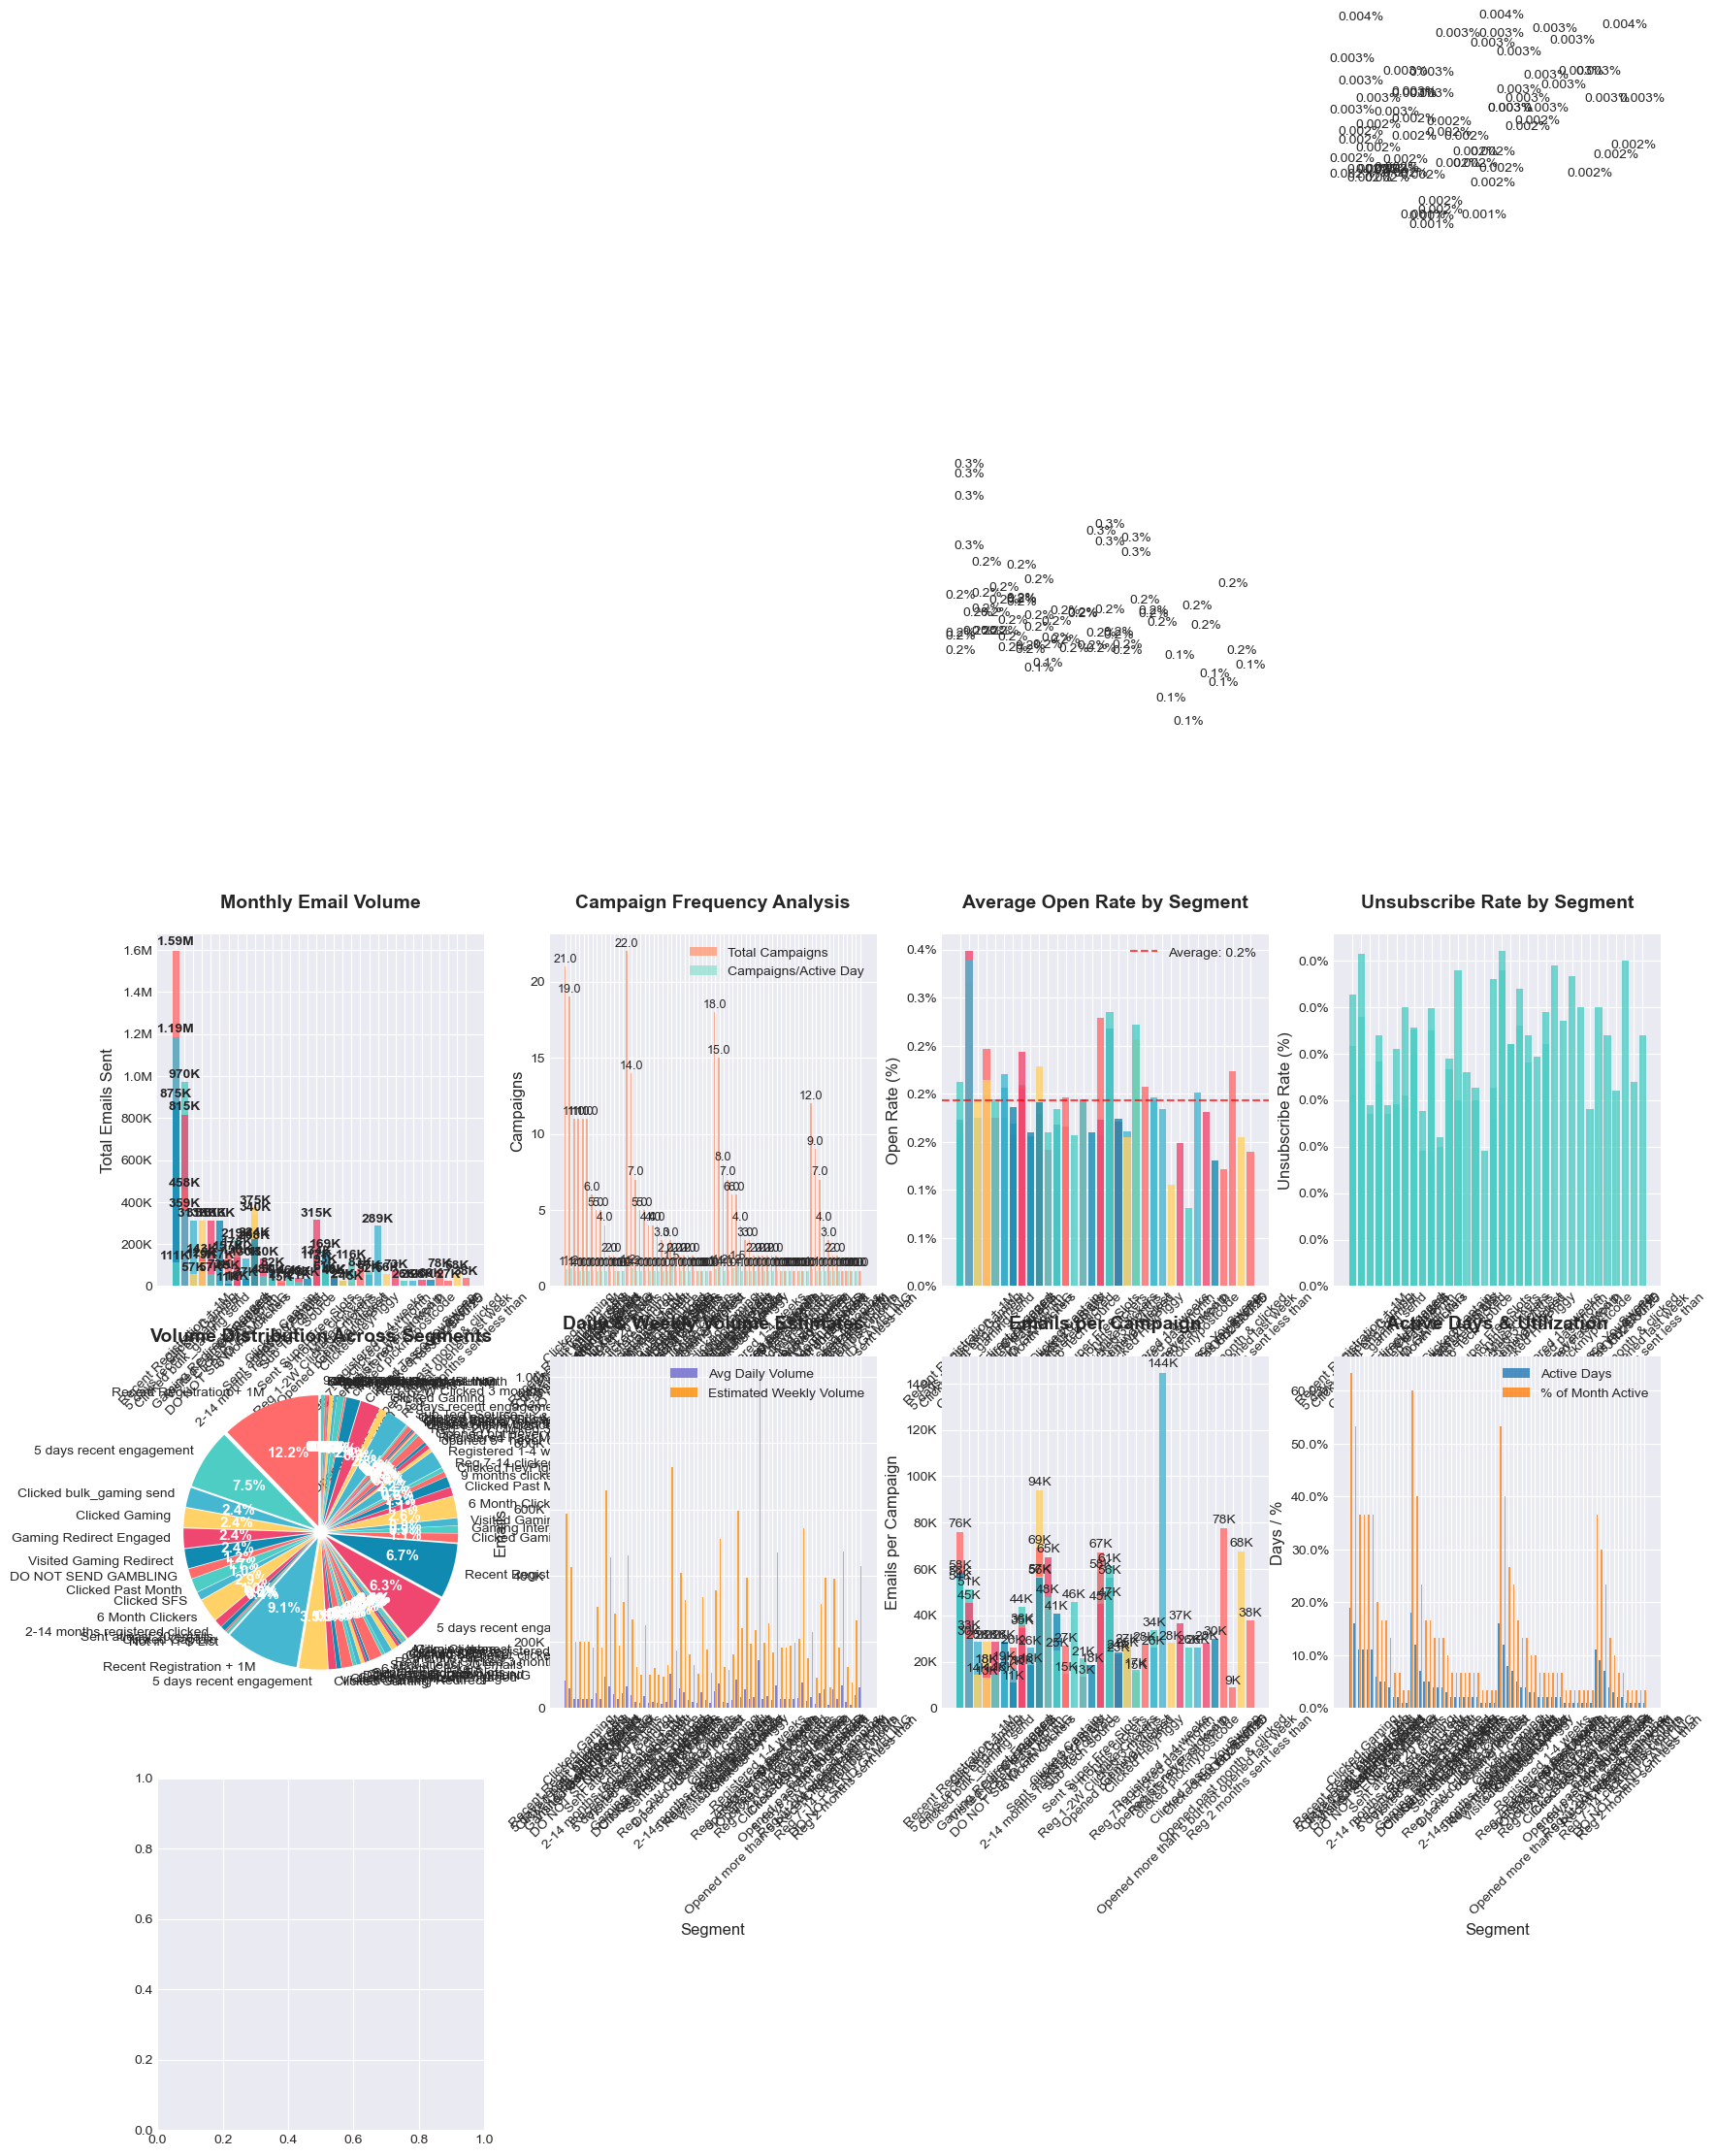

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

def format_large_numbers(x, pos):
    """Format large numbers for readability in charts"""
    if x >= 1e6:
        return f'{x/1e6:.1f}M'
    elif x >= 1e3:
        return f'{x/1e3:.0f}K'
    else:
        return f'{x:.0f}'

def format_percentage(x, pos):
    """Format percentages for readability"""
    return f'{x:.1f}%'

def analyze_email_segments_enhanced(dataframe):
    """
    Comprehensive analysis of email segments with engagement metrics
    
    Parameters:
    dataframe (pd.DataFrame): Input data with segment metrics including engagement
    
    Returns:
    dict: Dictionary containing insights, figure, and enhanced dataframe
    """
    
    # Create a copy to avoid modifying original
    df = dataframe.copy()
    
    # Calculate additional metrics
    df['avg_daily_volume'] = df['monthly_sent'] / df['active_days']
    df['avg_daily_volume'] = df['avg_daily_volume'].replace([np.inf, -np.inf], 0)
    df['emails_per_campaign'] = df['monthly_sent'] / df['monthly_campaigns']
    df['emails_per_campaign'] = df['emails_per_campaign'].replace([np.inf, -np.inf], 0)
    df['estimated_weekly_volume'] = df['avg_daily_volume'] * 7
    
    # Calculate campaign frequency (campaigns per active day)
    df['campaigns_per_active_day'] = df['monthly_campaigns'] / df['active_days']
    
    # Convert percentages to decimal for easier calculations
    df['avg_open_rate'] = df['avg_open_rate_pct'] / 100
    df['avg_unsub_rate'] = df['avg_unsub_rate_pct'] / 100
    
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 16))
    
    # Color palette
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFD166', '#EF476F', '#118AB2']
    
    # 1. Monthly Volume Comparison
    ax1 = plt.subplot(3, 4, 1)
    bars1 = ax1.bar(df['segment_name'], df['monthly_sent'], 
                    color=colors[:len(df)], alpha=0.8)
    ax1.set_title('Monthly Email Volume', fontsize=14, fontweight='bold', pad=20)
    ax1.set_ylabel('Total Emails Sent', fontsize=12)
    ax1.tick_params(axis='x', rotation=45)
    ax1.yaxis.set_major_formatter(FuncFormatter(format_large_numbers))
    
    # Add value labels
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height * 1.01,
                f'{height/1e6:.2f}M' if height >= 1e6 else f'{height/1e3:.0f}K', 
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # 2. Campaign Frequency Analysis
    ax2 = plt.subplot(3, 4, 2)
    x = np.arange(len(df['segment_name']))
    width = 0.35
    
    bars2a = ax2.bar(x - width/2, df['monthly_campaigns'], width, 
                     label='Total Campaigns', color='#FF9A76', alpha=0.8)
    bars2b = ax2.bar(x + width/2, df['campaigns_per_active_day'], width, 
                     label='Campaigns/Active Day', color='#95E1D3', alpha=0.8)
    
    ax2.set_title('Campaign Frequency Analysis', fontsize=14, fontweight='bold', pad=20)
    ax2.set_xlabel('Segment', fontsize=12)
    ax2.set_ylabel('Campaigns', fontsize=12)
    ax2.set_xticks(x)
    ax2.set_xticklabels(df['segment_name'], rotation=45)
    ax2.legend()
    
    # Add value labels
    for bars in [bars2a, bars2b]:
        for bar in bars:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'{height:.1f}', ha='center', va='bottom', fontsize=9)
    
    # 3. Engagement Metrics (Open Rate)
    ax3 = plt.subplot(3, 4, 3)
    bars3 = ax3.bar(df['segment_name'], df['avg_open_rate_pct'], 
                    color=colors[:len(df)], alpha=0.8)
    ax3.set_title('Average Open Rate by Segment', fontsize=14, fontweight='bold', pad=20)
    ax3.set_ylabel('Open Rate (%)', fontsize=12)
    ax3.tick_params(axis='x', rotation=45)
    ax3.yaxis.set_major_formatter(FuncFormatter(format_percentage))
    
    # Add value labels
    for bar in bars3:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=10)
    
    # Add a horizontal line for average open rate
    avg_open_rate = df['avg_open_rate_pct'].mean()
    ax3.axhline(y=avg_open_rate, color='red', linestyle='--', alpha=0.7, 
                label=f'Average: {avg_open_rate:.1f}%')
    ax3.legend()
    
    # 4. Churn Risk (Unsubscribe Rate)
    ax4 = plt.subplot(3, 4, 4)
    bars4 = ax4.bar(df['segment_name'], df['avg_unsub_rate_pct'], 
                    color=['#FF6B6B' if rate > 0.2 else '#4ECDC4' for rate in df['avg_unsub_rate_pct']], 
                    alpha=0.8)
    ax4.set_title('Unsubscribe Rate by Segment', fontsize=14, fontweight='bold', pad=20)
    ax4.set_ylabel('Unsubscribe Rate (%)', fontsize=12)
    ax4.tick_params(axis='x', rotation=45)
    ax4.yaxis.set_major_formatter(FuncFormatter(format_percentage))
    
    # Add value labels
    for bar in bars4:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}%', ha='center', va='bottom', fontsize=10)
    
    # 5. Volume Distribution (Pie Chart)
    ax5 = plt.subplot(3, 4, 5)
    total_volume = df['monthly_sent'].sum()
    percentages = (df['monthly_sent'] / total_volume * 100).round(1)
    
    wedges, texts, autotexts = ax5.pie(df['monthly_sent'], labels=df['segment_name'],
                                       autopct='%1.1f%%', colors=colors[:len(df)],
                                       startangle=90, explode=[0.05]*len(df))
    ax5.set_title('Volume Distribution Across Segments', fontsize=14, fontweight='bold', pad=20)
    
    # Make autopct text larger
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontsize(11)
        autotext.set_fontweight('bold')
    
    # 6. Daily and Weekly Volume Estimation
    ax6 = plt.subplot(3, 4, 6)
    x = np.arange(len(df['segment_name']))
    width = 0.35
    
    bars6a = ax6.bar(x - width/2, df['avg_daily_volume'], width,
                     label='Avg Daily Volume', color='#6A67CE', alpha=0.8)
    bars6b = ax6.bar(x + width/2, df['estimated_weekly_volume'], width,
                     label='Estimated Weekly Volume', color='#FF8E00', alpha=0.8)
    
    ax6.set_title('Daily & Weekly Volume Estimates', fontsize=14, fontweight='bold', pad=20)
    ax6.set_xlabel('Segment', fontsize=12)
    ax6.set_ylabel('Emails', fontsize=12)
    ax6.set_xticks(x)
    ax6.set_xticklabels(df['segment_name'], rotation=45)
    ax6.yaxis.set_major_formatter(FuncFormatter(format_large_numbers))
    ax6.legend()
    
    # 7. Campaign Intensity (Emails per Campaign)
    ax7 = plt.subplot(3, 4, 7)
    bars7 = ax7.bar(df['segment_name'], df['emails_per_campaign'], 
                    color=colors[:len(df)], alpha=0.8)
    ax7.set_title('Emails per Campaign', fontsize=14, fontweight='bold', pad=20)
    ax7.set_ylabel('Emails per Campaign', fontsize=12)
    ax7.tick_params(axis='x', rotation=45)
    ax7.yaxis.set_major_formatter(FuncFormatter(format_large_numbers))
    
    # Add value labels
    for bar in bars7:
        height = bar.get_height()
        ax7.text(bar.get_x() + bar.get_width()/2., height * 1.01,
                f'{height/1e3:.0f}K', ha='center', va='bottom', fontsize=10)
    
    # 8. Active Days Utilization
    ax8 = plt.subplot(3, 4, 8)
    # Calculate percentage of month active
    df['days_utilization_pct'] = (df['active_days'] / 30) * 100
    
    bars8a = ax8.bar(x - width/2, df['active_days'], width,
                     label='Active Days', color='#1F77B4', alpha=0.8)
    bars8b = ax8.bar(x + width/2, df['days_utilization_pct'], width,
                     label='% of Month Active', color='#FF7F0E', alpha=0.8)
    
    ax8.set_title('Active Days & Utilization', fontsize=14, fontweight='bold', pad=20)
    ax8.set_xlabel('Segment', fontsize=12)
    ax8.set_ylabel('Days / %', fontsize=12)
    ax8.set_xticks(x)
    ax8.set_xticklabels(df['segment_name'], rotation=45)
    ax8.yaxis.set_major_formatter(FuncFormatter(format_percentage))
    ax8.legend()
    
    # 9. Current Status Analysis
    ax9 = plt.subplot(3, 4, 9)
    
    # Map status to colors
    status_colors = {
        'HIGH FREQUENCY': '#FF6B6B',
        'MODERATE FREQUENCY': '#FFD166',
        'LOW FREQUENCY': '#4ECDC4'
    }
    
    df['status_color'] = df['emailing_status'].map(status_colors)
    
    bars9 = ax9.bar(range(len(df)), [1]*len(df),  # All bars same height
                    color=df['status_color'], alpha=0.8)
    ax9.set_title('Current Emailing Status', fontsize=14, fontweight='bold', pad=20)
    ax9.set_ylabel('Status', fontsize=12)
    ax9.set_xticks(range(len(df)))
    ax9.set_xticklabels(df['segment_name'], rotation=45)
    ax9.set_yticks([])  # Remove y ticks
    
    # Add status labels
    for i, (status, color) in enumerate(zip(df['emailing_status'], df['status_color'])):
        ax9.text(i, 0.5, status, ha='center', va='center', 
                fontsize=11, fontweight='bold', color='white')
    
    # 10. Performance vs Volume Scatter Plot
    ax10 = plt.subplot(3, 4, 10)
    
    scatter = ax10.scatter(df['monthly_sent'], df['avg_open_rate_pct'], 
                          s=df['avg_unsub_rate_pct']*5000 + 100,  # Bubble size based on unsub rate
                          c=df['monthly_campaigns'], cmap='viridis', 
                          alpha=0.7, edgecolors='black')
    
    ax10.set_title('Volume vs Performance Analysis', fontsize=14, fontweight='bold', pad=20)
    ax10.set_xlabel('Monthly Volume (emails)', fontsize=12)
    ax10.set_ylabel('Open Rate (%)', fontsize=12)
    ax10.xaxis.set_major_formatter(FuncFormatter(format_large_numbers))
    ax10.yaxis.set_major_formatter(FuncFormatter(format_percentage))
    
    # Add segment labels
    for i, segment in enumerate(df['segment_name']):
        ax10.annotate(segment, (df['monthly_sent'].iloc[i], df['avg_open_rate_pct'].iloc[i]),
                     xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    # Add colorbar for campaign frequency
    cbar = plt.colorbar(scatter, ax=ax10)
    cbar.set_label('Campaigns per Month', fontsize=11)
    
    # 11. Recommendation Analysis
    ax11 = plt.subplot(3, 4, 11)
    
    # Group recommendations
    recommendation_counts = df['recommendation'].value_counts()
    wedges2, texts2, autotexts2 = ax11.pie(recommendation_counts.values, 
                                           labels=recommendation_counts.index,
                                           autopct='%1.1f%%', colors=['#FF6B6B', '#FFD166', '#4ECDC4'],
                                           startangle=90)
    ax11.set_title('Recommendation Distribution', fontsize=14, fontweight='bold', pad=20)
    
    for autotext in autotexts2:
        autotext.set_color('white')
        autotext.set_fontsize(11)
        autotext.set_fontweight('bold')
    
    # 12. Pressure Index Calculation (Volume, Frequency, Engagement)
    ax12 = plt.subplot(3, 4, 12)
    
    # Calculate normalized metrics for pressure index
    df['volume_score'] = (df['monthly_sent'] / df['monthly_sent'].max() * 100) if df['monthly_sent'].max() > 0 else 0
    df['frequency_score'] = (df['monthly_campaigns'] / df['monthly_campaigns'].max() * 100) if df['monthly_campaigns'].max() > 0 else 0
    
    # Invert engagement metrics (higher unsub rate = higher pressure)
    df['unsub_pressure'] = (df['avg_unsub_rate'] / df['avg_unsub_rate'].max() * 100) if df['avg_unsub_rate'].max() > 0 else 0
    
    # Calculate composite pressure index
    df['pressure_index'] = (
        df['volume_score'] * 0.3 + 
        df['frequency_score'] * 0.4 + 
        df['unsub_pressure'] * 0.3
    )
    
    # Sort by pressure index
    df_sorted = df.sort_values('pressure_index', ascending=False).reset_index(drop=True)
    
    # Create horizontal bar chart
    y_pos = np.arange(len(df_sorted['segment_name']))
    bars12 = ax12.barh(y_pos, df_sorted['pressure_index'], 
                      color=plt.cm.RdYlGn_r(df_sorted['pressure_index']/100), 
                      alpha=0.8)
    
    ax12.set_yticks(y_pos)
    ax12.set_yticklabels(df_sorted['segment_name'])
    ax12.set_xlabel('Pressure Index (%)', fontsize=12)
    ax12.set_title('Segment Pressure Analysis', fontsize=14, fontweight='bold', pad=20)
    ax12.invert_yaxis()  # Highest pressure at top
    
    # Add value labels
    for i, (bar, value) in enumerate(zip(bars12, df_sorted['pressure_index'])):
        ax12.text(bar.get_width() + 2, bar.get_y() + bar.get_height()/2,
                 f'{value:.1f}%', va='center', fontsize=10)
    
    plt.suptitle('Email Segment Performance & Pressure Dashboard', fontsize=18, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    # Generate insights
    insights = generate_enhanced_insights(df)
    
    return {'figure': fig, 'insights': insights, 'enhanced_data': df}

def generate_enhanced_insights(dataframe):
    """
    Generate business insights from the enhanced dataset
    
    Parameters:
    dataframe (pd.DataFrame): Enhanced dataframe with all metrics
    
    Returns:
    str: Formatted insights text
    """
    
    if len(dataframe) == 0:
        return "No data available for analysis."
    
    # Calculate key metrics
    max_volume_segment = dataframe.loc[dataframe['monthly_sent'].idxmax()]
    max_open_segment = dataframe.loc[dataframe['avg_open_rate_pct'].idxmax()]
    max_unsub_segment = dataframe.loc[dataframe['avg_unsub_rate_pct'].idxmax()]
    max_campaign_segment = dataframe.loc[dataframe['monthly_campaigns'].idxmax()]
    max_pressure_segment = dataframe.loc[dataframe['pressure_index'].idxmax()]
    
    # Calculate averages
    avg_open_rate = dataframe['avg_open_rate_pct'].mean()
    avg_unsub_rate = dataframe['avg_unsub_rate_pct'].mean()
    avg_campaigns = dataframe['monthly_campaigns'].mean()
    avg_active_days = dataframe['active_days'].mean()
    
    # Volume distribution
    total_volume = dataframe['monthly_sent'].sum()
    volume_distribution = (dataframe['monthly_sent'] / total_volume * 100).round(1)
    
    # Segment with highest volume percentage
    top_volume_pct = volume_distribution.max()
    top_volume_segment_name = dataframe.loc[volume_distribution.idxmax(), 'segment_name']
    
    # Performance classification
    high_performers = dataframe[dataframe['avg_open_rate_pct'] > avg_open_rate]
    high_risk_segments = dataframe[dataframe['avg_unsub_rate_pct'] > avg_unsub_rate * 1.5]  # 50% above average
    
    insights = f"""
    📊 EMAIL SEGMENT PERFORMANCE INSIGHTS
    ======================================
    
    🎯 KEY PERFORMANCE INDICATORS:
    
    1. VOLUME & DISTRIBUTION:
       • Total monthly volume: {total_volume/1e6:.2f}M emails
       • "{top_volume_segment_name}" accounts for {top_volume_pct:.1f}% of total volume
       • Volume range: {dataframe['monthly_sent'].min()/1e3:.0f}K to {dataframe['monthly_sent'].max()/1e3:.0f}K per segment
       • Daily volume average: {dataframe['avg_daily_volume'].mean()/1e3:.0f}K emails/day
    
    2. CAMPAIGN FREQUENCY:
       • Average campaigns per month: {avg_campaigns:.1f}
       • Highest frequency: "{max_campaign_segment['segment_name']}" ({max_campaign_segment['monthly_campaigns']} campaigns)
       • Active days utilization: {avg_active_days:.1f} days/month ({avg_active_days/30*100:.1f}% of month)
    
    3. ENGAGEMENT METRICS:
       • Average open rate: {avg_open_rate:.1f}%
       • Highest open rate: "{max_open_segment['segment_name']}" ({max_open_segment['avg_open_rate_pct']:.1f}%)
       • Average unsubscribe rate: {avg_unsub_rate:.3f}%
       • Highest unsubscribe rate: "{max_unsub_segment['segment_name']}" ({max_unsub_segment['avg_unsub_rate_pct']:.3f}%)
    
    4. SEGMENT PERFORMANCE:
       • High performers (above avg open rate): {len(high_performers)} of {len(dataframe)} segments
       • High-risk segments (unsub > 50% above avg): {len(high_risk_segments)} segments
       • Campaign intensity: {dataframe['emails_per_campaign'].mean()/1e3:.1f}K emails per campaign average
    
    5. PRESSURE ANALYSIS:
       • Highest pressure segment: "{max_pressure_segment['segment_name']}" (Index: {max_pressure_segment['pressure_index']:.1f}%)
       • Average pressure index: {dataframe['pressure_index'].mean():.1f}%
       • Status distribution: {dataframe['emailing_status'].value_counts().to_dict()}
    
    🔍 CRITICAL OBSERVATIONS:
    
    1. VOLUME CONCENTRATION:
       {"⚠️  High concentration in top segment - consider volume redistribution" if top_volume_pct > 50 else "✅ Volume distribution appears balanced"}
    
    2. ENGAGEMENT HEALTH:
       {"⚠️  High unsubscribe rates detected in some segments" if len(high_risk_segments) > 0 else "✅ Unsubscribe rates appear healthy"}
       {"🎯 High open rate segments may tolerate higher frequency" if max_open_segment['avg_open_rate_pct'] > 25 else "📊 Open rates indicate room for improvement"}
    
    3. FREQUENCY MANAGEMENT:
       {"⚠️  High frequency segments may risk user fatigue" if max_campaign_segment['monthly_campaigns'] > 20 else "✅ Campaign frequency appears reasonable"}
    
    💡 STRATEGIC RECOMMENDATIONS:
    
    1. FREQUENCY OPTIMIZATION:
       • {f"Reduce frequency for '{max_pressure_segment['segment_name']}' as per recommendation: {max_pressure_segment['recommendation']}"}
       • Consider A/B testing reduced frequency for high-pressure segments
       • Monitor engagement metrics after frequency adjustments
    
    2. CONTENT STRATEGY:
       • Leverage high open rate segments ({max_open_segment['segment_name']}) for premium content
       • Test different content types for segments with declining engagement
       • Personalize messaging based on segment engagement patterns
    
    3. RISK MITIGATION:
       {"• Implement immediate frequency reduction for high-unsubscribe segments" if len(high_risk_segments) > 0 else "• Continue current strategy with close monitoring"}
       • Establish alerts for segments exceeding unsub rate thresholds
       • Develop re-engagement campaigns for at-risk segments
    
    4. LONG-TERM STRATEGY:
       • Implement dynamic frequency adjustment based on engagement scores
       • Develop segment-specific content calendars
       • Create a testing framework for optimal send times and frequencies
       • Establish quarterly reviews of segment performance and pressure indices
    
    📈 OPPORTUNITY AREAS:
    
    1. PERFORMANCE GAPS:
       • Open rate variance: {(max_open_segment['avg_open_rate_pct'] - dataframe['avg_open_rate_pct'].min()):.1f}% difference between best and worst
       • Potential uplift from optimizing underperforming segments
    
    2. EFFICIENCY IMPROVEMENT:
       • Campaign consolidation opportunities: {len(dataframe[dataframe['campaigns_per_active_day'] < 1])} segments with <1 campaign per active day
       • Volume consolidation potential in high-frequency, low-engagement segments
    
    3. SEGMENT DEVELOPMENT:
       • Consider creating sub-segments based on engagement levels
       • Develop targeted reactivation campaigns for low-engagement users
    """
    
    return insights

# Function to run analysis and display everything
def run_complete_analysis(df):
    """
    Run complete analysis and display results
    
    Parameters:
    df (pd.DataFrame): Your dataset
    """
    
    print("="*80)
    print("EMAIL SEGMENT ANALYSIS - VOLUME, ENGAGEMENT & PRESSURE ASSESSMENT")
    print("="*80)
    print(f"\nAnalyzing {len(df)} segments for {df['year'].iloc[0]}-{df['month'].iloc[0]}")
    print("_"*80)
    
    # Run analysis
    results = analyze_email_segments_enhanced(df)
    
    # Display charts
    plt.show()
    
    # Display insights
    print("\n" + "="*80)
    print("BUSINESS INSIGHTS & RECOMMENDATIONS")
    print("="*80)
    print(results['insights'])
    
    # Display enhanced data summary
    print("\n" + "="*80)
    print("ENHANCED DATA SUMMARY")
    print("="*80)
    
    summary_columns = ['segment_name', 'monthly_sent', 'monthly_campaigns', 
                      'avg_open_rate_pct', 'avg_unsub_rate_pct', 
                      'emailing_status', 'pressure_index', 'recommendation']
    
    display_df = results['enhanced_data'][summary_columns].copy()
    display_df['monthly_sent'] = display_df['monthly_sent'].apply(lambda x: f'{x/1e6:.2f}M' if x >= 1e6 else f'{x/1e3:.0f}K')
    display_df['pressure_index'] = display_df['pressure_index'].round(1).astype(str) + '%'
    display_df['avg_open_rate_pct'] = display_df['avg_open_rate_pct'].round(1).astype(str) + '%'
    display_df['avg_unsub_rate_pct'] = display_df['avg_unsub_rate_pct'].round(3).astype(str) + '%'
    
    print(display_df.to_string(index=False))
    
    return results

# To use this function:
results = run_complete_analysis(df)

# -- Identify segments carrying high monetization load

In [17]:
SQL_NAME = "4_/4_6"
result = await SqlQuery.read_sql(SQL_NAME)

# Run in Jupyter
df = await fetch_data(result)
df.head(3)

,segment_id,segment_name,total_campaigns,total_sent_all_time,total_revenue_generated,avg_revenue_per_campaign,revenue_per_email,avg_campaigns_per_month,monetization_load,dependency_risk
0,97,Recent Registration + 1M,60,3765580,27270.52,247.9138181818181818,0.00724205036143170508,15,HIGH LOAD: Primary monetization segment,CRITICAL: Over-reliant on this segment
1,150,5 days recent engagement,63,2602012,21261.91,208.4500980392156863,0.00817133433665947736,15,HIGH LOAD: Primary monetization segment,HIGH RISK: Heavy reliance
2,161,6 Month Clickers,17,1146689,9145.87,351.7642307692307692,0.00797589407415611382,4,MEDIUM LOAD: Secondary monetization,MANAGEABLE


SEGMENT MONETIZATION & DEPENDENCY RISK ANALYSIS

Analyzing 34 segments
________________________________________________________________________________


TypeError: unsupported operand type(s) for /: 'decimal.Decimal' and 'float'

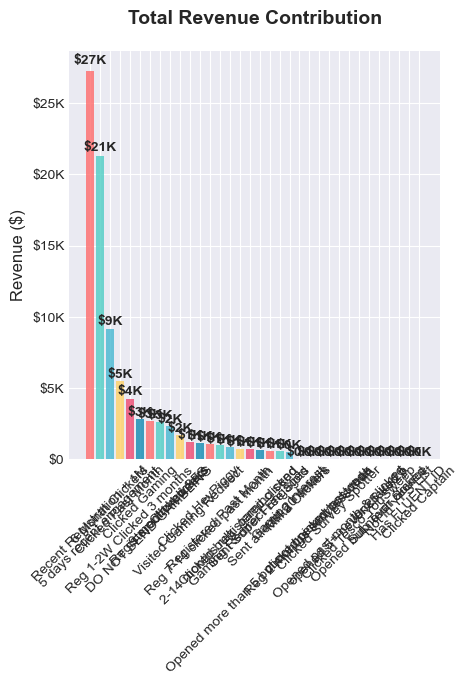

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

def format_large_numbers(x, pos):
    """Format large numbers for readability in charts"""
    if x >= 1e6:
        return f'{x/1e6:.1f}M'
    elif x >= 1e3:
        return f'{x/1e3:.0f}K'
    else:
        return f'{x:.0f}'

def format_currency(x, pos):
    """Format currency values for readability"""
    if x >= 1e6:
        return f'${x/1e6:.1f}M'
    elif x >= 1e3:
        return f'${x/1e3:.0f}K'
    else:
        return f'${x:.0f}'

def format_percentage(x, pos):
    """Format percentages for readability"""
    return f'{x:.1f}%'

def analyze_monetization_dependency(dataframe):
    """
    Comprehensive analysis of segment monetization and dependency risk
    
    Parameters:
    dataframe (pd.DataFrame): Input data with monetization and dependency metrics
    
    Returns:
    dict: Dictionary containing insights, figure, and enhanced dataframe
    """
    
    # Create a copy to avoid modifying original
    df = dataframe.copy()
    
    # Calculate additional metrics
    df['estimated_monthly_sent'] = (df['total_sent_all_time'] / df['total_campaigns'] * df['avg_campaigns_per_month']).round(0)
    df['revenue_per_thousand_emails'] = df['revenue_per_email'] * 1000
    df['campaign_revenue_efficiency'] = df['total_revenue_generated'] / df['total_campaigns']
    
    # Calculate concentration metrics
    total_revenue = df['total_revenue_generated'].sum()
    total_emails = df['total_sent_all_time'].sum()
    
    df['revenue_concentration'] = (df['total_revenue_generated'] / total_revenue * 100)
    df['volume_concentration'] = (df['total_sent_all_time'] / total_emails * 100)
    
    # Calculate dependency scores
    risk_mapping = {
        'MANAGEABLE': 1,
        'HIGH RISK: Heavy reliance': 3,
        'CRITICAL: Over-reliant on this segment': 5
    }
    
    load_mapping = {
        'MEDIUM LOAD: Secondary monetization': 2,
        'HIGH LOAD: Primary monetization segment': 4
    }
    
    df['risk_score'] = df['dependency_risk'].map(risk_mapping)
    df['load_score'] = df['monetization_load'].map(load_mapping)
    
    # Calculate dependency index
    df['dependency_index'] = df['risk_score'] * df['load_score'] / 10  # Normalize to 0-2.5 scale
    
    # Create figure with subplots
    fig = plt.figure(figsize=(22, 18))
    
    # Color palette
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFD166', '#EF476F', '#118AB2']
    
    # 1. Total Revenue Contribution
    ax1 = plt.subplot(3, 4, 1)
    bars1 = ax1.bar(df['segment_name'], df['total_revenue_generated'], 
                    color=colors[:len(df)], alpha=0.8)
    ax1.set_title('Total Revenue Contribution', fontsize=14, fontweight='bold', pad=20)
    ax1.set_ylabel('Revenue ($)', fontsize=12)
    ax1.tick_params(axis='x', rotation=45)
    ax1.yaxis.set_major_formatter(FuncFormatter(format_currency))
    
    # Add value labels
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height * 1.01,
                f'${height/1e3:.0f}K', 
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Add total revenue line
    ax1.axhline(y=total_revenue, color='red', linestyle='--', alpha=0.5, 
                label=f'Total: ${total_revenue/1e3:.0f}K')
    ax1.legend()
    
    # 2. Revenue Concentration Analysis
    ax2 = plt.subplot(3, 4, 2)
    x = np.arange(len(df['segment_name']))
    width = 0.35
    
    bars2a = ax2.bar(x - width/2, df['revenue_concentration'], width,
                     label='Revenue %', color='#1F77B4', alpha=0.8)
    bars2b = ax2.bar(x + width/2, df['volume_concentration'], width,
                     label='Volume %', color='#FF7F0E', alpha=0.8)
    
    ax2.set_title('Revenue vs Volume Concentration', fontsize=14, fontweight='bold', pad=20)
    ax2.set_xlabel('Segment', fontsize=12)
    ax2.set_ylabel('Percentage (%)', fontsize=12)
    ax2.set_xticks(x)
    ax2.set_xticklabels(df['segment_name'], rotation=45)
    ax2.yaxis.set_major_formatter(FuncFormatter(format_percentage))
    ax2.legend()
    
    # Add value labels
    for bars in [bars2a, bars2b]:
        for bar in bars:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
                    f'{height:.1f}%', ha='center', va='bottom', fontsize=9)
    
    # 3. Revenue Efficiency Metrics
    ax3 = plt.subplot(3, 4, 3)
    bars3a = ax3.bar(x - width/2, df['revenue_per_email'], width,
                     label='Revenue/Email ($)', color='#2E8B57', alpha=0.8)
    bars3b = ax3.bar(x + width/2, df['avg_revenue_per_campaign'], width,
                     label='Revenue/Campaign ($)', color='#8A2BE2', alpha=0.8)
    
    ax3.set_title('Revenue Efficiency Metrics', fontsize=14, fontweight='bold', pad=20)
    ax3.set_xlabel('Segment', fontsize=12)
    ax3.set_ylabel('Dollars ($)', fontsize=12)
    ax3.set_xticks(x)
    ax3.set_xticklabels(df['segment_name'], rotation=45)
    ax3.yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'${x:.2f}'))
    ax3.legend()
    
    # Add value labels
    for bars in [bars3a, bars3b]:
        for bar in bars:
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                    f'${height:.3f}' if height < 1 else f'${height:.1f}', 
                    ha='center', va='bottom', fontsize=9, rotation=90)
    
    # 4. Volume and Campaign Analysis
    ax4 = plt.subplot(3, 4, 4)
    
    # Create secondary axis
    ax4_secondary = ax4.twinx()
    
    bars4a = ax4.bar(x - width/2, df['total_sent_all_time'], width,
                     label='Total Emails Sent', color='#4682B4', alpha=0.7)
    bars4b = ax4.bar(x + width/2, df['estimated_monthly_sent'], width,
                     label='Est. Monthly Volume', color='#32CD32', alpha=0.7)
    
    # Plot campaign frequency as line
    line4 = ax4_secondary.plot(x, df['avg_campaigns_per_month'], 
                               color='#FF4500', marker='o', linewidth=3, 
                               label='Avg Campaigns/Month')
    
    ax4.set_title('Volume & Campaign Frequency', fontsize=14, fontweight='bold', pad=20)
    ax4.set_xlabel('Segment', fontsize=12)
    ax4.set_ylabel('Email Volume', fontsize=12)
    ax4.set_xticks(x)
    ax4.set_xticklabels(df['segment_name'], rotation=45)
    ax4.yaxis.set_major_formatter(FuncFormatter(format_large_numbers))
    ax4_secondary.set_ylabel('Campaigns per Month', fontsize=12)
    
    # Combine legends
    lines1, labels1 = ax4.get_legend_handles_labels()
    lines2, labels2 = ax4_secondary.get_legend_handles_labels()
    ax4.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    # 5. Monetization Load Analysis
    ax5 = plt.subplot(3, 4, 5)
    
    # Create horizontal bar chart for load scores
    df_sorted_load = df.sort_values('load_score', ascending=True).reset_index(drop=True)
    y_pos_load = np.arange(len(df_sorted_load['segment_name']))
    
    bars5 = ax5.barh(y_pos_load, df_sorted_load['load_score'], 
                     color=['#FF6B6B' if score >= 4 else '#FFD166' for score in df_sorted_load['load_score']], 
                     alpha=0.8)
    
    ax5.set_yticks(y_pos_load)
    ax5.set_yticklabels(df_sorted_load['segment_name'])
    ax5.set_xlabel('Load Score (1-4)', fontsize=12)
    ax5.set_title('Monetization Load Analysis', fontsize=14, fontweight='bold', pad=20)
    ax5.set_xlim(0, 5)
    
    # Add labels
    for i, (bar, load) in enumerate(zip(bars5, df_sorted_load['monetization_load'])):
        ax5.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2,
                load, va='center', fontsize=10)
    
    # 6. Dependency Risk Analysis
    ax6 = plt.subplot(3, 4, 6)
    
    # Create horizontal bar chart for risk scores
    df_sorted_risk = df.sort_values('risk_score', ascending=True).reset_index(drop=True)
    y_pos_risk = np.arange(len(df_sorted_risk['segment_name']))
    
    bars6 = ax6.barh(y_pos_risk, df_sorted_risk['risk_score'], 
                     color=['#FF6B6B' if score >= 4 else '#FFD166' if score >= 3 else '#4ECDC4' 
                            for score in df_sorted_risk['risk_score']], 
                     alpha=0.8)
    
    ax6.set_yticks(y_pos_risk)
    ax6.set_yticklabels(df_sorted_risk['segment_name'])
    ax6.set_xlabel('Risk Score (1-5)', fontsize=12)
    ax6.set_title('Dependency Risk Analysis', fontsize=14, fontweight='bold', pad=20)
    ax6.set_xlim(0, 6)
    
    # Add labels
    for i, (bar, risk) in enumerate(zip(bars6, df_sorted_risk['dependency_risk'])):
        ax6.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2,
                risk, va='center', fontsize=10)
    
    # 7. Dependency Index (Combined Load & Risk)
    ax7 = plt.subplot(3, 4, 7)
    
    df_sorted_dep = df.sort_values('dependency_index', ascending=True).reset_index(drop=True)
    y_pos_dep = np.arange(len(df_sorted_dep['segment_name']))
    
    # Create gradient colors based on dependency index
    norm_dep = plt.Normalize(df_sorted_dep['dependency_index'].min(), df_sorted_dep['dependency_index'].max())
    colors_dep = plt.cm.RdYlGn_r(norm_dep(df_sorted_dep['dependency_index']))
    
    bars7 = ax7.barh(y_pos_dep, df_sorted_dep['dependency_index'], 
                     color=colors_dep, alpha=0.8)
    
    ax7.set_yticks(y_pos_dep)
    ax7.set_yticklabels(df_sorted_dep['segment_name'])
    ax7.set_xlabel('Dependency Index (Higher = More Critical)', fontsize=12)
    ax7.set_title('Segment Dependency Index', fontsize=14, fontweight='bold', pad=20)
    
    # Add value labels
    for i, (bar, value) in enumerate(zip(bars7, df_sorted_dep['dependency_index'])):
        ax7.text(bar.get_width() + 0.05, bar.get_y() + bar.get_height()/2,
                f'{value:.2f}', va='center', fontsize=10)
    
    # 8. Revenue per Campaign Scatter Plot
    ax8 = plt.subplot(3, 4, 8)
    
    scatter8 = ax8.scatter(df['avg_campaigns_per_month'], df['avg_revenue_per_campaign'],
                          s=df['total_revenue_generated']/100,  # Size by total revenue
                          c=df['risk_score'], cmap='RdYlGn_r',
                          alpha=0.7, edgecolors='black')
    
    ax8.set_title('Campaign Frequency vs Revenue Efficiency', fontsize=14, fontweight='bold', pad=20)
    ax8.set_xlabel('Average Campaigns per Month', fontsize=12)
    ax8.set_ylabel('Average Revenue per Campaign ($)', fontsize=12)
    
    # Add segment labels
    for i, segment in enumerate(df['segment_name']):
        ax8.annotate(segment, (df['avg_campaigns_per_month'].iloc[i], 
                               df['avg_revenue_per_campaign'].iloc[i]),
                    xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    # Add trend line
    z = np.polyfit(df['avg_campaigns_per_month'], df['avg_revenue_per_campaign'], 1)
    p = np.poly1d(z)
    ax8.plot(df['avg_campaigns_per_month'], p(df['avg_campaigns_per_month']), 
             "r--", alpha=0.5, label='Trend Line')
    
    # Add colorbar
    cbar8 = plt.colorbar(scatter8, ax=ax8)
    cbar8.set_label('Risk Score', fontsize=11)
    ax8.legend()
    
    # 9. Campaign Efficiency Analysis
    ax9 = plt.subplot(3, 4, 9)
    
    bars9a = ax9.bar(x - width/2, df['total_campaigns'], width,
                     label='Total Campaigns', color='#20B2AA', alpha=0.8)
    bars9b = ax9.bar(x + width/2, df['campaign_revenue_efficiency'], width,
                     label='Revenue per Campaign ($)', color='#9370DB', alpha=0.8)
    
    ax9.set_title('Campaign Volume vs Efficiency', fontsize=14, fontweight='bold', pad=20)
    ax9.set_xlabel('Segment', fontsize=12)
    ax9.set_ylabel('Count / $', fontsize=12)
    ax9.set_xticks(x)
    ax9.set_xticklabels(df['segment_name'], rotation=45)
    ax9.yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{x:.0f}' if x < 1000 else f'{x/1e3:.0f}K'))
    ax9.legend()
    
    # 10. Revenue per Thousand Emails (Industry Benchmark Comparison)
    ax10 = plt.subplot(3, 4, 10)
    
    # Industry benchmark (hypothetical - adjust based on your industry)
    industry_benchmark = 5.0  # $5 per 1000 emails
    df['vs_benchmark'] = (df['revenue_per_thousand_emails'] / industry_benchmark * 100) - 100
    
    bars10 = ax10.bar(df['segment_name'], df['revenue_per_thousand_emails'], 
                      color=['#4ECDC4' if rpe > industry_benchmark else '#FF6B6B' 
                             for rpe in df['revenue_per_thousand_emails']], 
                      alpha=0.8)
    
    # Add benchmark line
    ax10.axhline(y=industry_benchmark, color='green', linestyle='--', 
                 alpha=0.7, label=f'Industry Benchmark: ${industry_benchmark}')
    
    ax10.set_title('Revenue per 1000 Emails vs Benchmark', fontsize=14, fontweight='bold', pad=20)
    ax10.set_ylabel('Revenue per 1000 Emails ($)', fontsize=12)
    ax10.tick_params(axis='x', rotation=45)
    ax10.legend()
    
    # Add value labels and performance indicator
    for i, (bar, value, vs) in enumerate(zip(bars10, df['revenue_per_thousand_emails'], df['vs_benchmark'])):
        ax10.text(bar.get_x() + bar.get_width()/2., value + 0.2,
                 f'${value:.2f}\n({vs:+.1f}%)', 
                 ha='center', va='bottom', fontsize=9)
    
    # 11. Portfolio Diversification Analysis
    ax11 = plt.subplot(3, 4, 11)
    
    # Calculate Herfindahl-Hirschman Index (HHI) for revenue concentration
    hhi_revenue = (df['revenue_concentration'] ** 2).sum() / 10000  # Normalize to 0-1 scale
    
    # Create pie chart for revenue diversification
    wedges, texts, autotexts = ax11.pie(df['revenue_concentration'], labels=df['segment_name'],
                                        autopct='%1.1f%%', colors=colors[:len(df)],
                                        startangle=90)
    ax11.set_title(f'Revenue Concentration\nHHI: {hhi_revenue:.3f} ({get_hhi_category(hhi_revenue)})', 
                   fontsize=14, fontweight='bold', pad=20)
    
    # Make autopct text larger
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontsize(11)
        autotext.set_fontweight('bold')
    
    # 12. Strategic Prioritization Matrix
    ax12 = plt.subplot(3, 4, 12)
    
    # Create bubble chart: Risk vs Revenue Contribution
    scatter12 = ax12.scatter(df['risk_score'], df['revenue_concentration'],
                            s=df['total_revenue_generated']/100,
                            c=df['dependency_index'], cmap='RdYlGn_r',
                            alpha=0.7, edgecolors='black')
    
    ax12.set_title('Strategic Prioritization Matrix', fontsize=14, fontweight='bold', pad=20)
    ax12.set_xlabel('Risk Score (Higher = More Risky)', fontsize=12)
    ax12.set_ylabel('Revenue Contribution (%)', fontsize=12)
    
    # Add quadrants
    ax12.axhline(y=100/len(df), color='gray', linestyle='-', alpha=0.3)
    ax12.axvline(x=3, color='gray', linestyle='-', alpha=0.3)
    
    # Add quadrant labels
    ax12.text(1, 30, 'Low Risk\nLow Revenue', ha='center', va='center', 
              fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))
    ax12.text(1, 60, 'Low Risk\nHigh Revenue', ha='center', va='center', 
              fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7))
    ax12.text(4, 30, 'High Risk\nLow Revenue', ha='center', va='center', 
              fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral", alpha=0.7))
    ax12.text(4, 60, 'High Risk\nHigh Revenue', ha='center', va='center', 
              fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="orange", alpha=0.7))
    
    # Add segment labels
    for i, segment in enumerate(df['segment_name']):
        ax12.annotate(segment, (df['risk_score'].iloc[i], df['revenue_concentration'].iloc[i]),
                     xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    # Add colorbar
    cbar12 = plt.colorbar(scatter12, ax=ax12)
    cbar12.set_label('Dependency Index', fontsize=11)
    
    plt.suptitle('Segment Monetization & Dependency Risk Dashboard', fontsize=18, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    # Generate insights
    insights = generate_monetization_insights(df, total_revenue, total_emails)
    
    return {'figure': fig, 'insights': insights, 'enhanced_data': df}

def get_hhi_category(hhi_value):
    """Categorize HHI score"""
    if hhi_value > 0.25:
        return 'Highly Concentrated'
    elif hhi_value > 0.15:
        return 'Moderately Concentrated'
    else:
        return 'Diversified'

def generate_monetization_insights(dataframe, total_revenue, total_emails):
    """
    Generate business insights from monetization and dependency data
    
    Parameters:
    dataframe (pd.DataFrame): Enhanced dataframe with calculated metrics
    total_revenue (float): Total revenue across all segments
    total_emails (float): Total emails sent across all segments
    
    Returns:
    str: Formatted insights text
    """
    
    if len(dataframe) == 0:
        return "No data available for analysis."
    
    df = dataframe.copy()
    
    # Calculate key metrics
    max_revenue_segment = df.loc[df['total_revenue_generated'].idxmax()]
    max_volume_segment = df.loc[df['total_sent_all_time'].idxmax()]
    max_efficiency_segment = df.loc[df['revenue_per_email'].idxmax()]
    max_risk_segment = df.loc[df['risk_score'].idxmax()]
    max_dependency_segment = df.loc[df['dependency_index'].idxmax()]
    
    # Calculate concentration metrics
    revenue_concentration = df['revenue_concentration'].max()
    volume_concentration = df['volume_concentration'].max()
    
    # Calculate HHI for revenue concentration
    hhi_revenue = (df['revenue_concentration'] ** 2).sum() / 10000
    
    # Calculate average metrics
    avg_revenue_per_email = df['revenue_per_email'].mean()
    avg_revenue_per_campaign = df['avg_revenue_per_campaign'].mean()
    avg_campaigns_per_month = df['avg_campaigns_per_month'].mean()
    
    # Calculate efficiency ratios
    avg_revenue_per_thousand = avg_revenue_per_email * 1000
    
    # Industry benchmark (adjust based on your industry)
    industry_benchmark = 5.0  # $5 per 1000 emails
    overall_vs_benchmark = (avg_revenue_per_thousand / industry_benchmark * 100) - 100
    
    insights = f"""
    📊 MONETIZATION & DEPENDENCY RISK ANALYSIS
    ===========================================
    
    🎯 KEY FINANCIAL METRICS:
    
    1. REVENUE OVERVIEW:
       • Total Revenue Generated: ${total_revenue:,.0f}
       • Total Emails Sent: {total_emails:,.0f}
       • Overall Revenue per Email: ${avg_revenue_per_email:.6f}
       • Overall Revenue per 1000 Emails: ${avg_revenue_per_thousand:.2f}
       • vs Industry Benchmark ({industry_benchmark}): {overall_vs_benchmark:+.1f}%
    
    2. SEGMENT PERFORMANCE:
       • Top Revenue Generator: "{max_revenue_segment['segment_name']}" (${max_revenue_segment['total_revenue_generated']:,.0f})
       • Most Efficient Segment: "{max_efficiency_segment['segment_name']}" (${max_efficiency_segment['revenue_per_email']:.6f} per email)
       • Highest Volume Segment: "{max_volume_segment['segment_name']}" ({max_volume_segment['total_sent_all_time']:,.0f} emails)
    
    3. CONCENTRATION ANALYSIS:
       • Revenue Concentration: {revenue_concentration:.1f}% in top segment
       • Volume Concentration: {volume_concentration:.1f}% in top segment
       • HHI Score: {hhi_revenue:.3f} ({get_hhi_category(hhi_revenue)})
       • Campaigns per Month Range: {df['avg_campaigns_per_month'].min()} to {df['avg_campaigns_per_month'].max()}
    
    ⚠️ RISK ASSESSMENT:
    
    1. DEPENDENCY RISKS:
       • Highest Risk Segment: "{max_risk_segment['segment_name']}" ({max_risk_segment['dependency_risk']})
       • Highest Dependency Index: "{max_dependency_segment['segment_name']}" ({max_dependency_segment['dependency_index']:.2f})
       • Risk Distribution: {dict(zip(df['segment_name'], df['dependency_risk']))}
    
    2. MONETIZATION LOAD:
       • Load Distribution: {dict(zip(df['segment_name'], df['monetization_load']))}
       • Primary Revenue Segments: {len(df[df['monetization_load'].str.contains('PRIMARY', case=False)])} of {len(df)}
       • Secondary Revenue Segments: {len(df[df['monetization_load'].str.contains('SECONDARY', case=False)])} of {len(df)}
    
    🔍 CRITICAL FINDINGS:
    
    1. CONCENTRATION RISKS:
       {"🚨 CRITICAL: High revenue concentration detected - business is overly dependent on few segments" 
        if revenue_concentration > 50 else 
        "⚠️ WARNING: Moderate concentration - consider diversifying revenue sources" 
        if revenue_concentration > 30 else 
        "✅ GOOD: Revenue is well diversified across segments"}
    
    2. EFFICIENCY ANALYSIS:
       {"🚨 CRITICAL: Revenue per email below industry average - efficiency improvement needed" 
        if avg_revenue_per_thousand < industry_benchmark else 
        "✅ GOOD: Revenue efficiency exceeds industry average"}
    
    3. DEPENDENCY CONCERNS:
       {"🚨 CRITICAL: Multiple segments with high dependency risk" 
        if len(df[df['risk_score'] >= 4]) > 1 else 
        "⚠️ WARNING: Single point of failure identified" 
        if len(df[df['risk_score'] >= 4]) == 1 else 
        "✅ GOOD: Dependency risks appear manageable"}
    
    💡 STRATEGIC RECOMMENDATIONS:
    
    1. REVENUE DIVERSIFICATION:
       • {"Immediately develop alternative revenue streams for high-risk segments" 
          if revenue_concentration > 50 else 
          "Continue current diversification efforts with focus on underperforming segments"}
       • Invest in developing "{df.loc[df['revenue_concentration'].idxmin()]['segment_name']}" as a secondary revenue source
       • Test new monetization strategies with current high-performing segments
    
    2. RISK MITIGATION:
       • {"Implement immediate risk reduction plan for critical segments" 
          if len(df[df['risk_score'] >= 4]) > 0 else 
          "Develop contingency plans for primary revenue segments"}
       • Create segment-specific risk mitigation strategies
       • Establish monitoring alerts for dependency risk thresholds
    
    3. EFFICIENCY OPTIMIZATION:
       • Focus on improving revenue per email for "{df.loc[df['revenue_per_email'].idxmin()]['segment_name']}"
       • Optimize campaign frequency based on revenue efficiency analysis
       • Test different content and offer strategies in high-volume, low-efficiency segments
    
    4. LONG-TERM STRATEGY:
       • Target revenue concentration goal: <30% in any single segment
       • Develop 3 new revenue-generating segments within next 6 months
       • Implement A/B testing framework for monetization optimization
       • Establish quarterly reviews of dependency risk and concentration metrics
    
    📈 OPPORTUNITY IDENTIFICATION:
    
    1. UNTAPPED POTENTIAL:
       • Segment with highest efficiency but low volume: "{df.loc[df['revenue_per_email'].idxmax()]['segment_name']}"
       • Opportunity to scale efficient segments: Increase volume by {100 * (1/df['revenue_concentration'].max() - 1):.0f}% while maintaining efficiency
       • Cross-selling opportunities between high-engagement and high-revenue segments
    
    2. OPTIMIZATION TARGETS:
       • Campaign frequency optimization: Segments with >15 campaigns/month but <${industry_benchmark/1000:.4f} per email
       • Content optimization: Segments with high volume but below-average efficiency
       • Segmentation refinement: Consider sub-segmenting based on revenue contribution
    
    3. GROWTH STRATEGY:
       • Focus resources on segments with dependency index < {df['dependency_index'].mean():.2f}
       • Develop tiered monetization strategy based on segment value
       • Implement dynamic pricing or offer strategies based on segment efficiency
    """
    
    return insights

def run_monetization_analysis(df):
    """
    Run complete monetization analysis and display results
    
    Parameters:
    df (pd.DataFrame): Your dataset
    """
    
    print("="*80)
    print("SEGMENT MONETIZATION & DEPENDENCY RISK ANALYSIS")
    print("="*80)
    print(f"\nAnalyzing {len(df)} segments")
    print("_"*80)
    
    # Calculate totals for insights
    total_revenue = df['total_revenue_generated'].sum()
    total_emails = df['total_sent_all_time'].sum()
    
    # Run analysis
    results = analyze_monetization_dependency(df)
    
    # Display charts
    plt.show()
    
    # Display insights
    print("\n" + "="*80)
    print("BUSINESS INSIGHTS & STRATEGIC RECOMMENDATIONS")
    print("="*80)
    print(results['insights'])
    
    # Display enhanced data summary
    print("\n" + "="*80)
    print("ENHANCED DATA SUMMARY")
    print("="*80)
    
    summary_columns = ['segment_name', 'total_revenue_generated', 'total_sent_all_time',
                      'revenue_per_email', 'avg_revenue_per_campaign', 
                      'revenue_concentration', 'volume_concentration',
                      'monetization_load', 'dependency_risk', 'dependency_index']
    
    display_df = results['enhanced_data'][summary_columns].copy()
    
    # Format columns for display
    display_df['total_revenue_generated'] = display_df['total_revenue_generated'].apply(
        lambda x: f'${x/1e3:.0f}K')
    display_df['total_sent_all_time'] = display_df['total_sent_all_time'].apply(
        lambda x: f'{x/1e6:.2f}M' if x >= 1e6 else f'{x/1e3:.0f}K')
    display_df['revenue_per_email'] = display_df['revenue_per_email'].apply(
        lambda x: f'${x:.6f}')
    display_df['avg_revenue_per_campaign'] = display_df['avg_revenue_per_campaign'].apply(
        lambda x: f'${x:.1f}')
    display_df['revenue_concentration'] = display_df['revenue_concentration'].apply(
        lambda x: f'{x:.1f}%')
    display_df['volume_concentration'] = display_df['volume_concentration'].apply(
        lambda x: f'{x:.1f}%')
    display_df['dependency_index'] = display_df['dependency_index'].apply(
        lambda x: f'{x:.2f}')
    
    print(display_df.to_string(index=False))
    
    # Display risk matrix summary
    print("\n" + "="*80)
    print("RISK PRIORITIZATION MATRIX")
    print("="*80)
    
    risk_matrix = results['enhanced_data'][['segment_name', 'risk_score', 'load_score', 
                                          'revenue_concentration', 'dependency_index']].copy()
    risk_matrix = risk_matrix.sort_values('dependency_index', ascending=False)
    
    # Categorize segments
    conditions = [
        (risk_matrix['dependency_index'] >= 1.5),
        (risk_matrix['dependency_index'] >= 1.0),
        (risk_matrix['dependency_index'] < 1.0)
    ]
    choices = ['🚨 Immediate Action', '⚠️ Monitor Closely', '✅ Stable']
    risk_matrix['priority'] = np.select(conditions, choices)
    
    print(risk_matrix.to_string(index=False))
    
    return results

# Additional helper function for detailed segment analysis
def generate_segment_report_card(df, segment_name):
    """
    Generate a detailed report card for a specific segment
    
    Parameters:
    df (pd.DataFrame): Enhanced dataframe from analysis
    segment_name (str): Name of segment to analyze
    """
    
    segment_data = df[df['segment_name'] == segment_name]
    
    if len(segment_data) == 0:
        print(f"Segment '{segment_name}' not found.")
        return
    
    segment = segment_data.iloc[0]
    
    print(f"\n📋 REPORT CARD: {segment_name}")
    print("="*60)
    
    print(f"\n📊 PERFORMANCE METRICS:")
    print(f"   • Total Revenue: ${segment['total_revenue_generated']:,.0f}")
    print(f"   • Total Emails Sent: {segment['total_sent_all_time']:,.0f}")
    print(f"   • Revenue per Email: ${segment['revenue_per_email']:.6f}")
    print(f"   • Revenue per Campaign: ${segment['avg_revenue_per_campaign']:.1f}")
    print(f"   • Estimated Monthly Volume: {segment['estimated_monthly_sent']:,.0f}")
    
    print(f"\n⚠️  RISK ASSESSMENT:")
    print(f"   • Monetization Load: {segment['monetization_load']}")
    print(f"   • Dependency Risk: {segment['dependency_risk']}")
    print(f"   • Risk Score: {segment['risk_score']}/5")
    print(f"   • Load Score: {segment['load_score']}/4")
    print(f"   • Dependency Index: {segment['dependency_index']:.2f}")
    
    print(f"\n🎯 STRATEGIC POSITION:")
    print(f"   • Revenue Concentration: {segment['revenue_concentration']:.1f}%")
    print(f"   • Volume Concentration: {segment['volume_concentration']:.1f}%")
    print(f"   • Campaigns per Month: {segment['avg_campaigns_per_month']}")
    
    print(f"\n💡 RECOMMENDATIONS:")
    
    # Generate specific recommendations based on metrics
    recommendations = []
    
    if segment['dependency_index'] >= 1.5:
        recommendations.append("• IMMEDIATE: Implement risk mitigation strategies")
        recommendations.append("• Develop alternative revenue sources")
        recommendations.append("• Reduce dependency through segmentation")
    
    if segment['revenue_per_email'] < 0.005:
        recommendations.append("• Optimize monetization strategy for higher yield")
        recommendations.append("• Test different offers or pricing")
        recommendations.append("• Review content relevance and engagement")
    
    if segment['avg_campaigns_per_month'] > 15:
        recommendations.append("• Consider frequency optimization")
        recommendations.append("• Test reduced frequency with same revenue targets")
        recommendations.append("• Monitor engagement metrics closely")
    
    if segment['revenue_concentration'] > 40:
        recommendations.append("• Diversify revenue streams")
        recommendations.append("• Develop backup segments")
        recommendations.append("• Implement gradual volume redistribution")
    
    if not recommendations:
        recommendations.append("• Maintain current strategy with close monitoring")
        recommendations.append("• Continue optimization efforts")
        recommendations.append("• Explore growth opportunities")
    
    for rec in recommendations:
        print(rec)

# To use the complete analysis:
results = run_monetization_analysis(df)

# To generate individual segment report:
generate_segment_report_card(results['enhanced_data'], "Recent Registration + 1M")